<div class="alert alert-block alert-success" align = "Center">
    <h1>Pulizia del dataset</h1>
</div>

Nel Notebook2 si presenta la pulizia del dataset.

La pulizia ha occupato una buona parte del tempo e nei prossimi notebook si faranno delle considerazioni sui seguenti modelli:
+ Il dataset fornito;
+ Il dataset fornito senza outliers;
+ Il dataset pulito;
+ Il dataset pulito senza outliers.

Quindi, oltre all'individuazione di possibili outliers che potrebbero compromettere il buon risultato dei modelli, si presentano qui di seguito le modifiche apportate alle feature del dataset che si sono ritenute valide.

Inoltre nel Notebook3.2 si applicherà la RFECV sul modello Random Forest così da ridurre ulteriormente il numero di features su cui i modelli verranno costruiti e testati.

Si è scelto di apportare le seguenti modifiche:

* Si è deciso di modificare le scale di qualità in numeri; in questo modo l'albero di decisione dovrebbe riuscire a individuare meglio la soglia da adottare;
* Si sono tolte delle features;
* Si sono aggiunte delle features per aumentare la quantità di informazione presente nel dataset.
* Si sono trasformate delle feature categoriali in feature numeriche binarie;
* Sistemazione di feature ambigue.

In questo Notebook vengono effettuati dei comandi in modo da trasformare alcuni dataframe, ottenuti durante il processo di pulizia, in file csv, in modo da non dover ripetere le stesse procedure anche nei notebook successivi.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor 
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

In [2]:
df_out = pd.read_csv('dataset_enc.csv')

Si visualizza la shape del dataset fornito.

In [3]:
df_out.shape

(2930, 354)

Man mano che verranno apportate delle modifiche la shape verrà visualizzata per verificare che tutto sia come ci si aspetta.

<div class="alert alert-block alert-warning" align = "center">
    <h1>OUTLIERS SUL DATASET DI INPUT</h1>
</div>

Il seguente metodo di individuazione degli outliers sarà il medesimo adottato per individuare gli outliers sul dataset dopo la pulizia.

Gli outliers sono istanze dissimili dalla maggior parte delle istanze che compongono il dataset. Essi inficiano sul risultato finale di una predizione andando a condizionarla, si è deciso dunque di individuarli ed eliminarli.

Qui di seguito viene effettuato un lavoro di ricerca incrociata grazie a due modelli: 

>Local Outlier Factor: il funzionamento è simile al modello KNN, ovvero segna come outliers tutte le istanze che hanno meno di k vicini;

>Isolation Forest: seleziona randomicamente una feature e poi fa uno split randomico selezionando un valore tra il più grande e il più piccolo di tale feature. L'esecuzione di tale modello è ricorsiva, motivo per il quale viene denominata Forest.

Verranno eliminate solo le istanze che vengono individuate come outliers da ambo i modelli sopra citati.

In [4]:
def split(dataframe):
    # Si toglie la colonna da predire
    X = dataframe.drop(columns=['Sale_Price'], axis =1)

    # Si isola la colonna da predire
    y = dataframe['Sale_Price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 3)
    
    return X_train, X_test, y_train, y_test

In [5]:
X_train_80, X_test, y_train_80, y_test = split(df_out)

<div class="alert alert-block alert-success" align = "center">
    <h1>LocalOutlierFactor</h1>
</div>

➤ Come già annunaciato, il primo modello è il Local Outlier Factor o LOF e si basa su un concetto di densità locale, dove la località è data da i k vicini più vicini, la cui distanza viene utilizzata per stimare la densità. 

Confrontando la densità locale di un oggetto con le densità locali dei suoi vicini, si possono identificare regioni di densità simile e punti che hanno una densità sostanzialmente inferiore rispetto ai loro vicini. Questi sono considerati come valori anomali e etichettati come "outliers".


In [6]:
def Outliers_LOF(X_train, y_train):
    
    # Creazione del LocalOutlierFactor  
    LOF = LocalOutlierFactor(n_neighbors = 10, contamination=0.1)
    y_pred = LOF.fit_predict(X_train)
    
    # Individuazione degli outliers
    n_out = 0
    n_norm = 0
    for i in range(len(y_pred)):
        if (y_pred[i] < 0):
            n_out += 1
        else:
            n_norm += 1

    # Si crea un dataframe temporaneo per salvarsi le predizioni
    df = pd.DataFrame({'id' : X_train_80['id'], 'y_pred_LOF': y_pred})
        
    # Se ci sono valori NaN, si sostituiscono con 1 per non rischiare di eliminare istanze potenzalmente rilevanti
    df['y_pred_LOF'].fillna(1)  

    # Si ritorna il numero di outliers, di punti "normali" e i valori predetti
    return n_out, n_norm, df

In [7]:
num_LOF, num_norm_LOF, LOF_out = Outliers_LOF(X_train_80, y_train_80)

In [8]:
print("Numero di outliers con LOF: ", num_LOF)
print("Numero di inliers con LOF: ", num_norm_LOF)

Numero di outliers con LOF:  235
Numero di inliers con LOF:  2109


<div class="alert alert-block alert-success" align = "center">
    <h1>IsolationForest</h1>
</div>

➤ L'isolation forest ha lo scopo di individuare le anomalie nei dati. Ciò è fatto isolando gli outliers scegliendo casualmente una feature e poi facendo uno split scegliendo un numero compreso tra il vaore massimo e minimo della colonna. Questo lo si fa per produrre dei cammini più piccoli in caso si tratti di outliers. 

L'individuazione degli outliers risulta facile e viene effettuata ricorsivamente:

1. Si esegue lo split di una feature random;

2. Si seleziona un valore randomico compreso tra il max e il min valore della colonna;

3. Si crea l'albero;

4. Si trovano i dati col cammino più piccolo;

5. Si esegue la chiamata ricorsiva sull'albero.

In [9]:
def Outliers_IF(X_train, y_train):
    
    # Creazione dell'IsolationForest 
    IF = IsolationForest(n_estimators = 100, contamination = 0.03, max_samples ='auto', random_state = 15)
    y_pred = IF.fit_predict(X_train)

    # Individuazione degli outliers
    n_out = 0
    n_norm = 0
    for i in range(len(y_pred)):
        if (y_pred[i] < 0):
            n_out += 1
        else:
            n_norm += 1
    
    # Si crea un dataframe temporaneo per salvarsi le predizioni
    df = pd.DataFrame({'id' : X_train_80['id'], 'y_pred_IF': y_pred})
    
    # Se ci sono valori NaN, si sostituiscono con 1 per non rischiare di eliminare istanze potenzalmente rilevanti
    df['y_pred_IF'].fillna(1)  

    # Si ritorna il numero di outliers, di punti "normali" e i valori predetti
    return n_out, n_norm, df

In [10]:
num_IF, num_norm_IF, IF_out = Outliers_IF(X_train_80, y_train_80)

C:\Users\Serena\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [11]:
print("Numero di outliers con IF: ", num_IF)
print("Numero di inliers con IF: ", num_norm_IF)

Numero di outliers con IF:  71
Numero di inliers con IF:  2273


<div class="alert alert-block alert-success" align = "center">
    <h1>Outliers comuni</h1>
</div>

In [12]:
def Common_Outliers(X_train, y_train, LOF, IF):    
    
    # Si crea un dataframe concatenando gli ID e le predizioni dei 2 rilevatori di outliers
    temp_pred = pd.concat([LOF['id'], LOF['y_pred_LOF'], IF['y_pred_IF']], axis = 1)
    
    # Dal dataframe appena creato se ne crea un altro con la colonna 'Out' che permette di discriminare i punti outliers da quelli che non lo sono
    temp_out = pd.DataFrame(temp_pred, columns = ['y_pred_IF', 'y_pred_LOF', 'Out'])
    temp_out.fillna(-1, inplace = True)
    
    # I punti che non sono outliers hanno il corrispettivo valore in colonna 'Out' pari a 1
    temp_out.loc[temp_out['y_pred_LOF'] > 0, 'Out'] = 1
    temp_out.loc[temp_out['y_pred_IF'] > 0, 'Out'] = 1
    
    # Si concatena il training-set con il nuovo dataframe
    temp_train = pd.concat([X_train, temp_out], axis = 1)

    # Si individuano gli indici dei punti outliers
    indexNames = temp_train[temp_train['Out'] == -1 ].index
    
    # Si eliminano le righe corrispondenti agli inidici appena calcolati sul training-set (X e y)
    temp_train.drop(indexNames , inplace = True)
    y_train.drop(indexNames, inplace = True)
    
    # Si eliminano le colonne aggiunte dalla concatenazione
    temp_train.drop(columns = ['y_pred_LOF', 'y_pred_IF', 'Out'], axis = 1, inplace = True)
    
    return temp_train, y_train

In [13]:
X_train_no_out, y_train_no_out = Common_Outliers(X_train_80, y_train_80, LOF_out, IF_out)

Si verifica se il numero di righe è effettivamente cambiato.

In [14]:
X_train_no_out.shape

(2323, 353)

In [15]:
y_train_no_out.shape

(2323,)

I seguenti comandi servono per trasformare i dataframe senza outliers in un file csv.

In [16]:
df_no_out = pd.concat([X_train_no_out, y_train_no_out], axis = 1)

In [17]:
df_no_out.to_csv(r'training_wo_outliers.csv', index = False)

<div class="alert alert-block alert-warning" align = "center">
    <h1>FEATURES</h1>
</div>

Dato che le features categoriche sono state trasformate con il One-Hot Encoding è necessario richiamare il dataset originale perchè alcune modifiche si basano sulle etichette assunte da tali features.

In [18]:
df_features = pd.read_csv('dataset_iniziale.csv')

Si visualizza la shape del dataset fornito.

In [19]:
df_features.shape

(2930, 82)

<div class="alert alert-block alert-success" align = "center">
    <h1>HeatMap</h1>
</div>

Si mostra ora un grafico che rappresenta la relazione tra le varie features: 
- Più è scura la cella, minore è la correlazione tra le feature in ascissa e ordinata; 
- Più è chiara la cella, maggiore è la correlazione tra le feature in ascissa e ordinata.

C:\Users\Serena\AppData\Local\Temp\ipykernel_8948\2296492186.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  g = sns.heatmap(df_features.corr(), annot = True, fmt = ".1f")


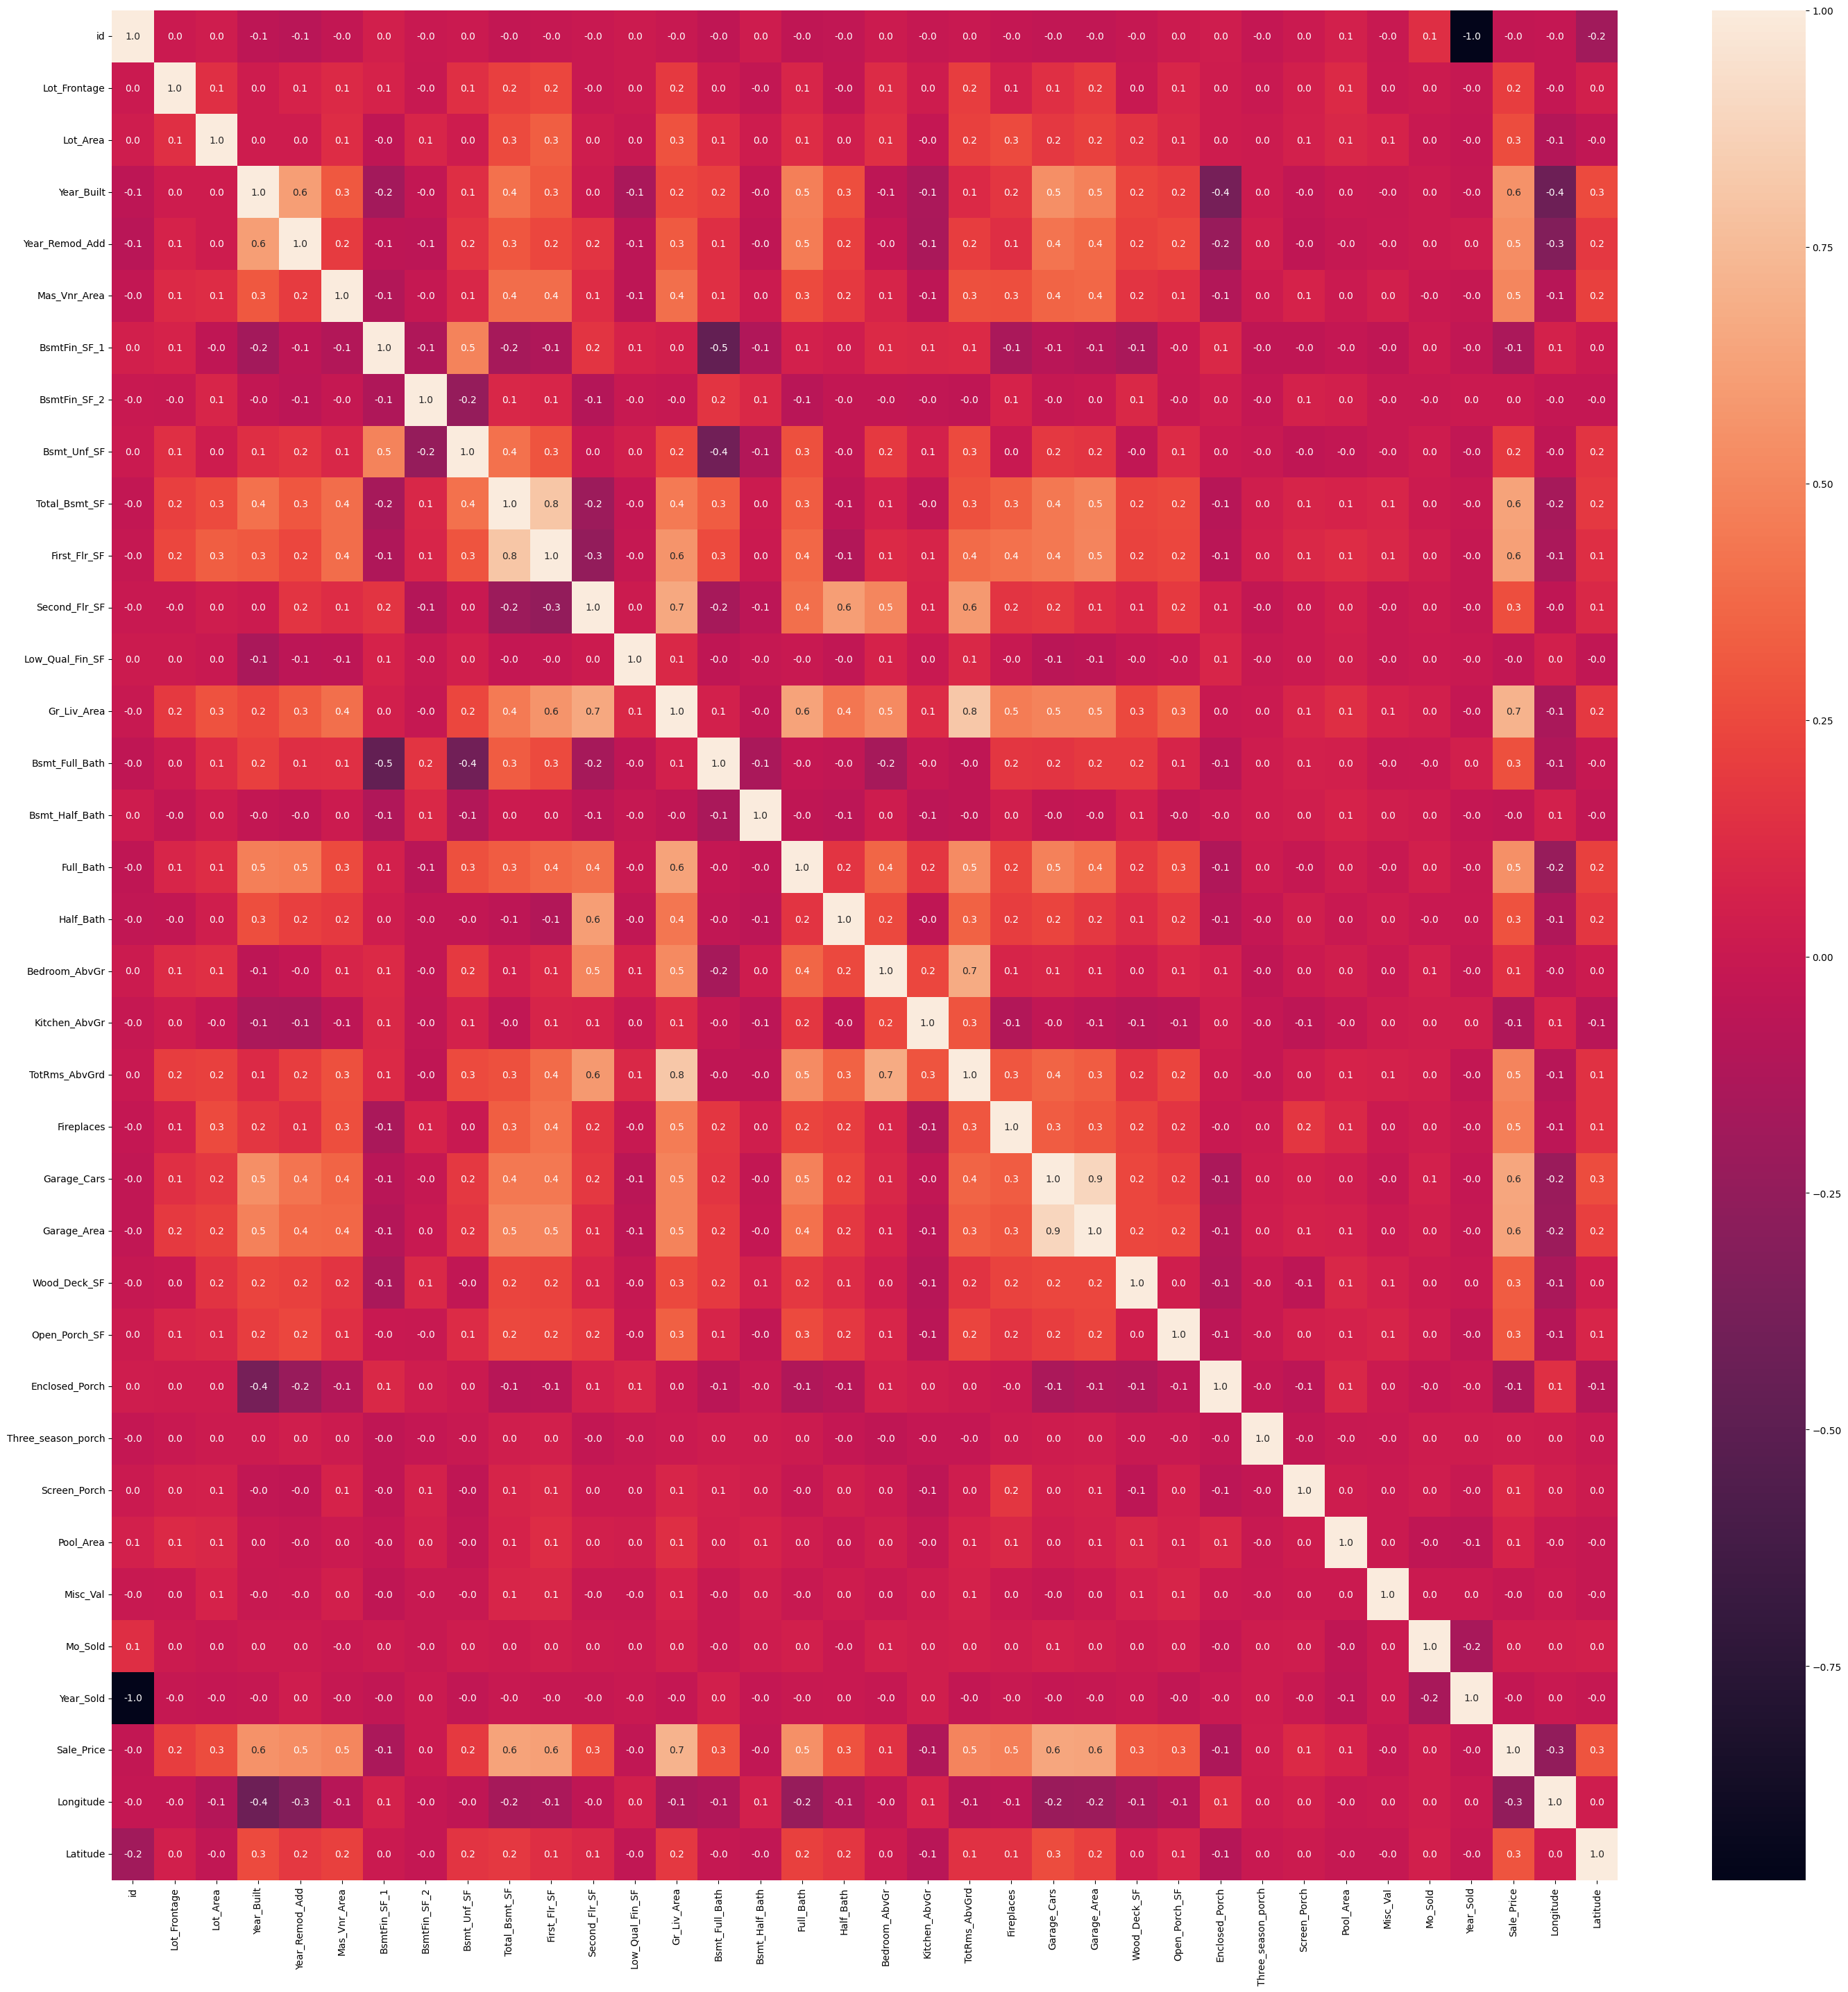

In [20]:
plt.rcParams['figure.figsize'] = (35,35)
g = sns.heatmap(df_features.corr(), annot = True, fmt = ".1f")

Banalmente, la diagonale principale è tutta pari a 1 perchè è l'incrocio di una feature con se stessa.

<div class="alert alert-block alert-success" align = "center">
    <h1>Scale di qualità</h1>
</div>

Come annunciato precedentemente si è scelto di trasformare le scale di qualità in scale numeriche per agevolare i modelli nel processo di apprendimento.

In [21]:
def quality_to_numeric(dataframe):

    # Sostituzione per 'Overall_Qual'
    dataframe['Overall_Qual'].replace(to_replace = ['Very_Poor', 'Poor', 'Below_Average', 'Average','Above_Average',
                               'Fair', 'Good', 'Very_Good', 'Excellent', 'Very_Excellent'],
                  value= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], inplace = True)

    # Sostituzione per 'Overall_Cond'
    dataframe['Overall_Cond'].replace(to_replace = ['Very_Poor', 'Poor', 'Below_Average', 'Average', 'Above_Average', 'Fair', 'Good',
                                             'Very_Good', 'Excellent'],
                  value = [0, 1, 2, 3, 4, 5, 6, 7, 8], inplace = True)

    # Sostituzione per 'Exter_Qual'
    dataframe['Exter_Qual'].replace(to_replace = ['Typical', 'Fair', 'Good', 'Excellent'],
                  value = [0, 1, 2, 3], inplace = True) 

    # Sostituzione per 'Exter_Cond'
    dataframe['Exter_Cond'].replace(to_replace = ['Poor', 'Typical', 'Fair', 'Good', 'Excellent'],
                  value = [0, 1, 2, 3, 4], inplace = True) 

    # Sostituzione per 'Bsmt_Qual'
    dataframe['Bsmt_Qual'].replace(to_replace = ['No_Basement', 'Poor', 'Typical', 'Fair', 'Good', 'Excellent'],
                  value = [0, 1, 2, 3, 4, 5], inplace = True) 

    # Sostituzione per 'Bsmt_Cond'
    dataframe['Bsmt_Cond'].replace(to_replace = ['No_Basement', 'Poor', 'Typical', 'Fair', 'Good', 'Excellent'],
                  value = [0, 1, 2, 3, 4, 5], inplace = True) 
    
    # Sostituzione per 'Bsmt_Exposure'
    dataframe['Bsmt_Exposure'].replace(to_replace = ['No_Basement','No', 'Mn', 'Av', 'Gd'],
                  value = [0, 1, 2, 3, 4], inplace = True)
    
    # Sostituzione per 'BsmtFin_Type_1'
    dataframe['BsmtFin_Type_1'].replace(to_replace = ['No_Basement', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
                  value = [0, 1, 2, 3, 4, 5, 6], inplace = True)
    
    # Sostituzione per 'BsmtFin_Type_2'
    dataframe['BsmtFin_Type_2'].replace(to_replace = ['No_Basement', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
                  value = [0, 1, 2, 3, 4, 5, 6], inplace = True)

    # Sostituzione per 'Heating_QC'
    dataframe['Heating_QC'].replace(to_replace = ['Poor', 'Typical', 'Fair', 'Good', 'Excellent'],
                  value = [0, 1, 2, 3, 4], inplace = True)

    # Sostituzione per 'Kitchen_Qual'
    dataframe['Kitchen_Qual'].replace(to_replace = ['Poor', 'Typical', 'Fair', 'Good', 'Excellent'],
                  value = [0, 1, 2, 3, 4], inplace = True)

    # Sostituzione per 'Fireplace_Qu'
    dataframe['Fireplace_Qu'].replace(to_replace = ['No_Fireplace', 'Poor', 'Typical', 'Fair', 'Good', 'Excellent'],
                  value = [0, 1, 2, 3, 4, 5], inplace = True)

    # Sostituzione per 'Garage_Qual'
    dataframe['Garage_Qual'].replace(to_replace = ['No_Garage', 'Poor', 'Typical', 'Fair', 'Good', 'Excellent'],
                  value = [0, 1, 2, 3, 4, 5], inplace = True)

    # Sostituzione per 'Garage_Cond'
    dataframe['Garage_Cond'].replace(to_replace = ['No_Garage', 'Poor', 'Typical', 'Fair', 'Good', 'Excellent'],
                  value = [0, 1, 2, 3, 4, 5], inplace = True)

    # Sostituzione per 'Pool_QC'
    dataframe['Pool_QC'].replace(to_replace = ['No_Pool', 'Typical', 'Fair', 'Good', 'Excellent'],
                  value = [0, 1, 2, 3, 4], inplace = True)

In [22]:
quality_to_numeric(df_features)

Come esempio, viene mostrata come ora si presenta la feature `Overall_Qual`:

In [23]:
df_features['Overall_Qual']

0       4
1       3
2       4
3       6
4       3
       ..
2925    4
2926    3
2927    3
2928    3
2929    6
Name: Overall_Qual, Length: 2930, dtype: int64

<div class="alert alert-block alert-success" align = "center">
    <h1>Drops</h1>
</div>

Si è scelto di togliere la feature `id` dato che ai fini della predizione è un'informazione non rilevante.

In [24]:
# Si toglie la colonna 'id'
df_features = df_features.drop('id', axis = 1)

Si verifica se il numero di colonne è effettivamente cambiato.

In [25]:
df_features.shape

(2930, 81)

Si presentano nuovamente i nomi delle colonne:

In [26]:
df_features.columns

Index(['MS_SubClass', 'MS_Zoning', 'Lot_Frontage', 'Lot_Area', 'Street',
       'Alley', 'Lot_Shape', 'Land_Contour', 'Utilities', 'Lot_Config',
       'Land_Slope', 'Neighborhood', 'Condition_1', 'Condition_2', 'Bldg_Type',
       'House_Style', 'Overall_Qual', 'Overall_Cond', 'Year_Built',
       'Year_Remod_Add', 'Roof_Style', 'Roof_Matl', 'Exterior_1st',
       'Exterior_2nd', 'Mas_Vnr_Type', 'Mas_Vnr_Area', 'Exter_Qual',
       'Exter_Cond', 'Foundation', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure',
       'BsmtFin_Type_1', 'BsmtFin_SF_1', 'BsmtFin_Type_2', 'BsmtFin_SF_2',
       'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'Heating', 'Heating_QC', 'Central_Air',
       'Electrical', 'First_Flr_SF', 'Second_Flr_SF', 'Low_Qual_Fin_SF',
       'Gr_Liv_Area', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Full_Bath',
       'Half_Bath', 'Bedroom_AbvGr', 'Kitchen_AbvGr', 'Kitchen_Qual',
       'TotRms_AbvGrd', 'Functional', 'Fireplaces', 'Fireplace_Qu',
       'Garage_Type', 'Garage_Finish', 'Garage_Cars', 'G

Solalmente a partire dai nomi delle feature si è scelto di eliminare alcune feature:

+ La feature `Garage_Cars` è stata eliminata;
+ Le feature `Latitude` e `Longitude` sono state eliminate;

Qui di seguito vengono presentati i motivi di tali scelte:

1. Si è eliminata `Garage_Cars` perchè il numero di automobili che un garage può contenere è strettamente dipendente dall'area di quest'ultimo, in altre parole, è un'informazione ripetuta;
2. `Latitude` e `Longitude` sono informazioni riguardanti la zona in cui l'abitazione è situata, ma risultano essere troppo specifiche ai fini di una predizione di prezzo e, inoltre, sono assimilate dalla feature `Neighborhood`;

In [27]:
df_features = df_features.drop('Garage_Cars', axis = 1)

In [28]:
df_features = df_features.drop(columns = ['Latitude', 'Longitude'] , axis = 1)

Si verifica se il numero di colonne è effettivamente cambiato.

In [29]:
df_features.shape

(2930, 78)

<div class="alert alert-block alert-success" align = "center">
    <h1>Aggiunta di features</h1>
</div>

Durante l'analisi del dataset, si è deciso di aggiungere delle feature:
+ Numero totale di bagni nel seminterrato;
+ Numero toale di bagni nei piani superiori al seminterrato;
+ Superficie totale del primo e del secondo piano dell'abitazione;
+ Presenza di piscine;
+ Presenza e area di porticati;
+ Prezzo medio per vicinato.

<div class="alert alert-block alert-info" align = "center">
    <h1>Numero totale di bagni nel seminterrato</h1>
</div>

Per aggiungere il numero totale di bagni presenti nel seminterrato è necessario costruire un altro dataframe su cui poter lavorare temporaneamente per poi concatenarlo con il dataset principale.

In [30]:
def Total_Bsmt_Baths(dataframe):
    
    # Dataframe temporaneo
    temp_df = pd.DataFrame(dataframe, columns = ['Bsmt_Baths'])
    # k rappresenta l'indice delle righe della nuova colonna
    k = 0
    for i, v in zip(dataframe['Bsmt_Full_Bath'], dataframe['Bsmt_Half_Bath']):
        # Somma dei mezzi bagni e dei bagni completi
        temp_df['Bsmt_Baths'][k] = i + v
        k += 1
    
    return temp_df

In [31]:
temp_df = Total_Bsmt_Baths(df_features)

Si indaga ora sull'eventuale relazione che la nuova feature ha coi prezzi delle abitazioni.

Text(0, 0.5, 'Sale_Price')

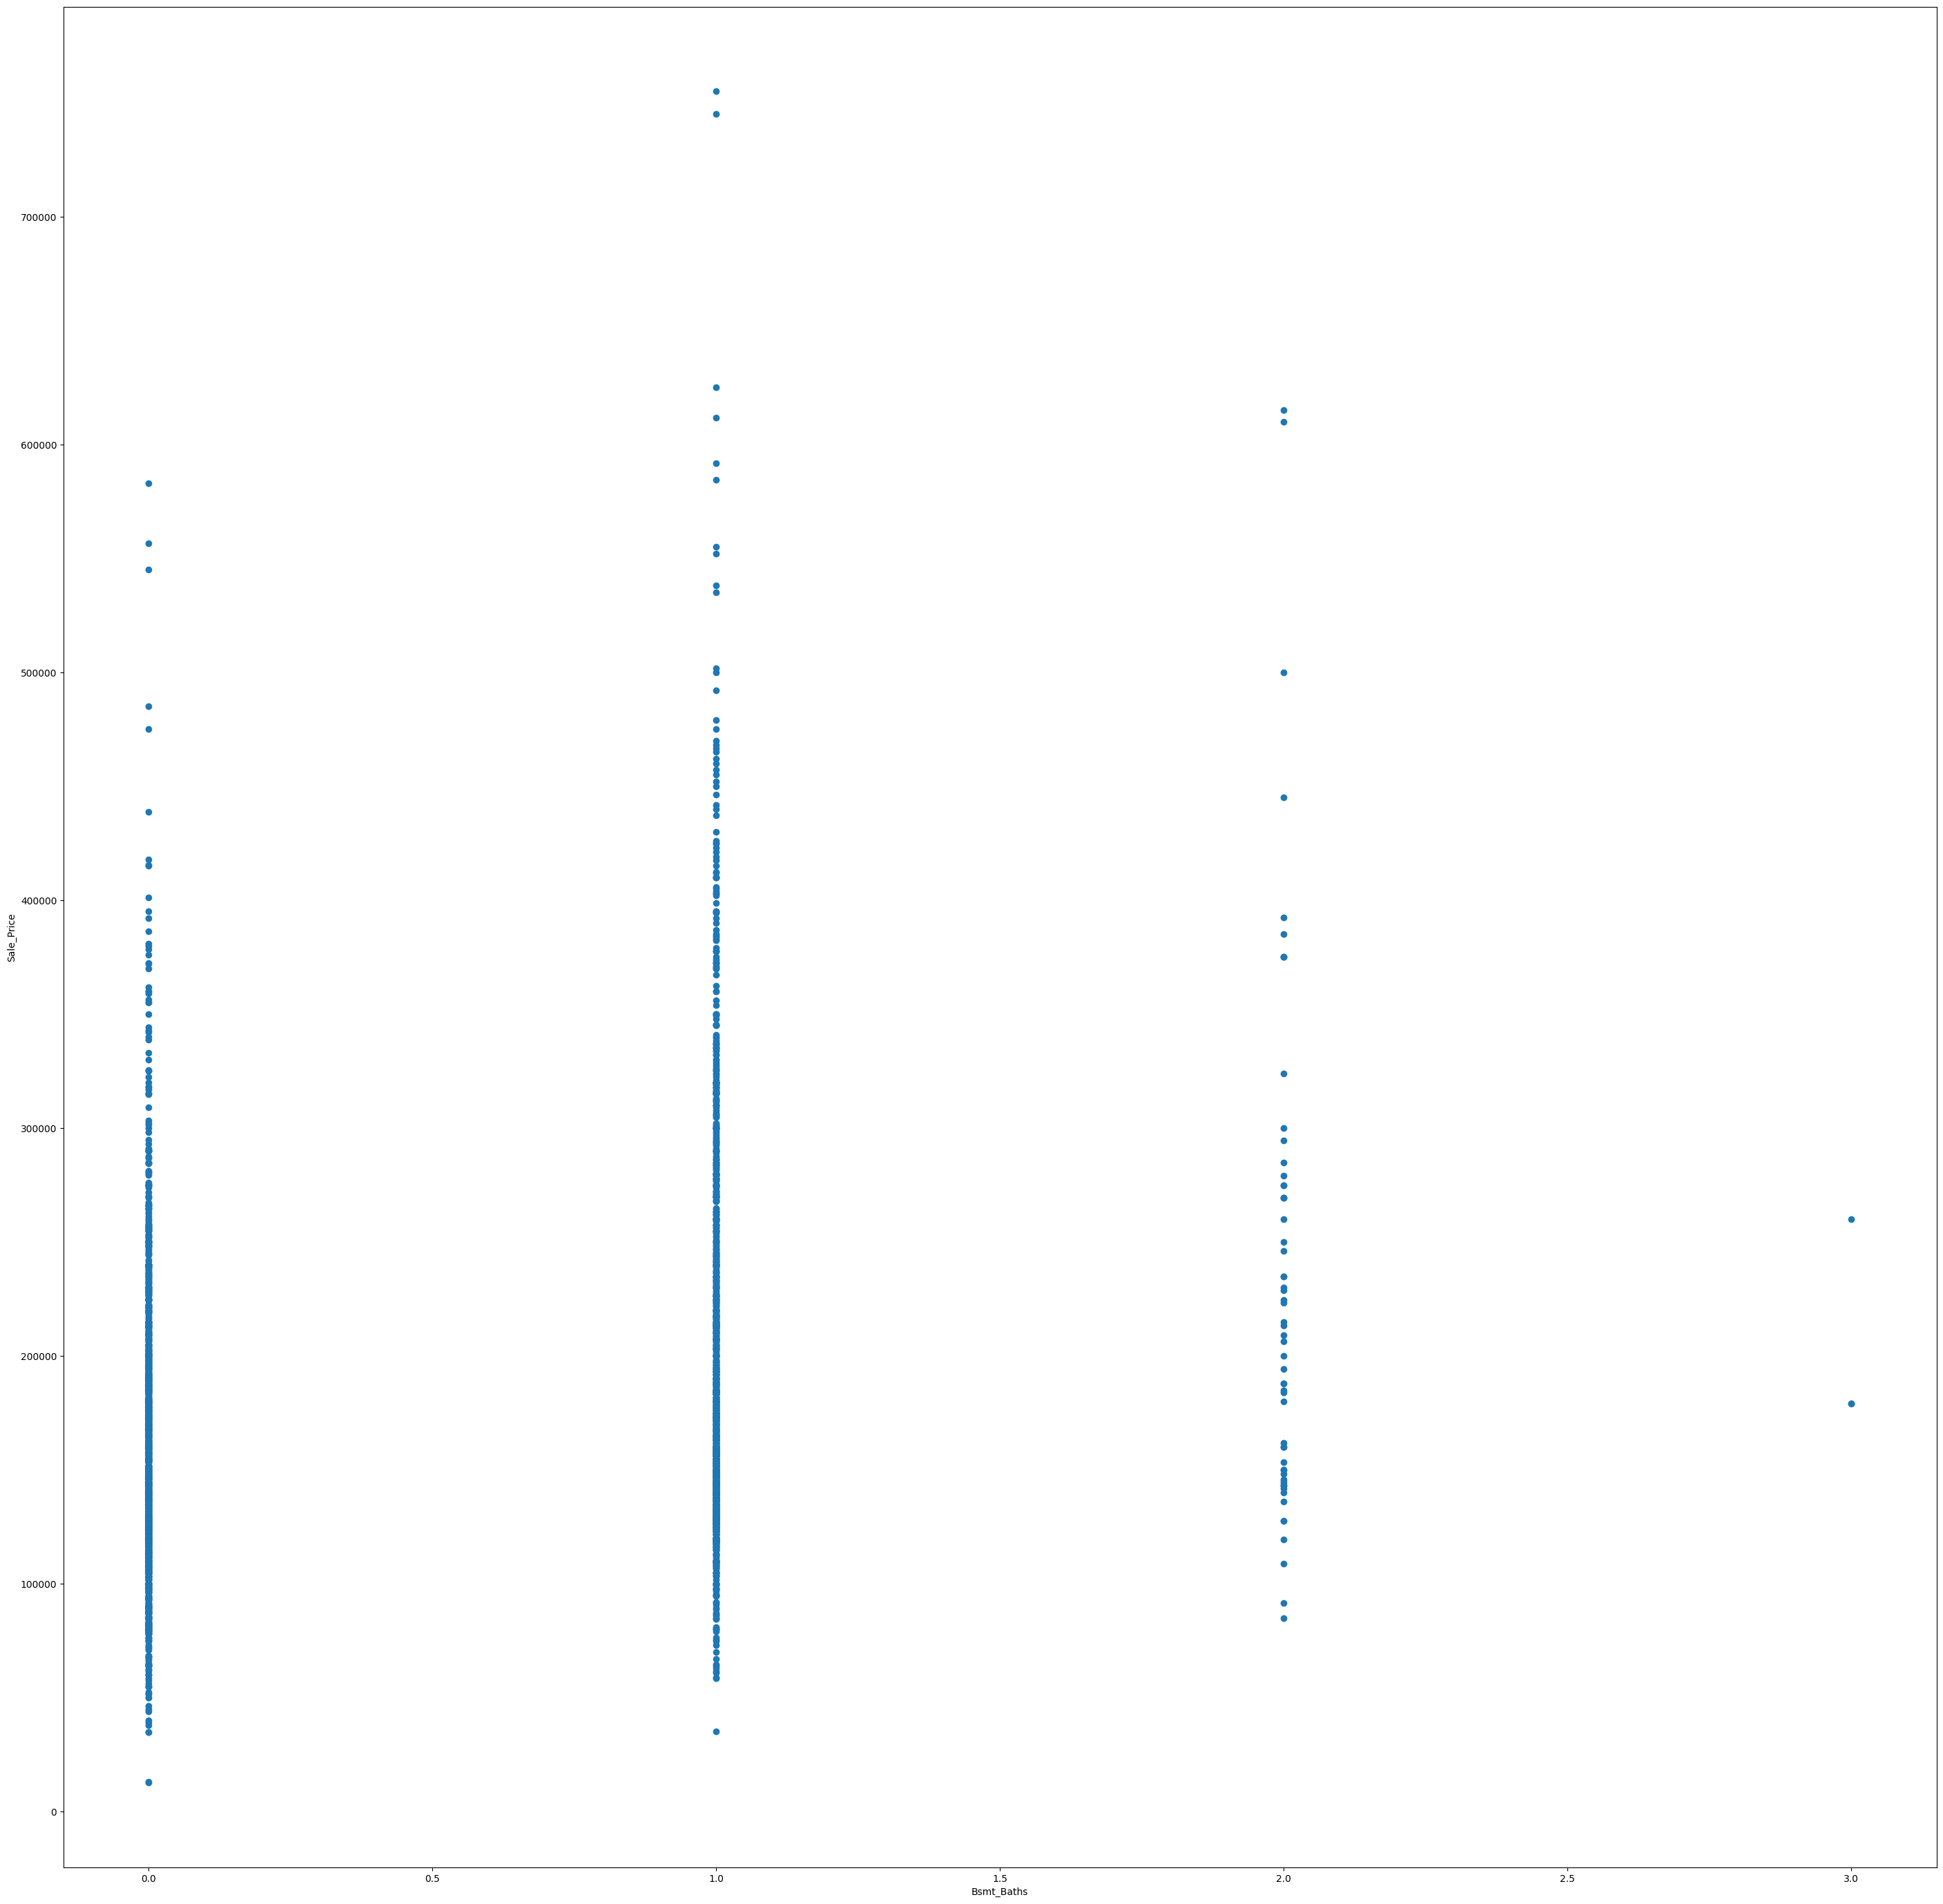

In [32]:
fig, ax = plt.subplots()
ax.scatter(temp_df['Bsmt_Baths'], df_features['Sale_Price'])
plt.xlabel('Bsmt_Baths')
plt.ylabel('Sale_Price')

Dal grafico si nota che i prezzi più bassi delle abitazioni che contengono almeno un bagno nel seminterrato sono superiori al prezzo più basso di un'abitazione che non ha un bagno nel seminterrato, nonostante i prezzi varino molto anche in presenza di 1, 2 o 3 bagni. 

Data questa relazione si ritiene opportuno eliminare le feature `Bsmt_Full_Bath` e `Bsmt_Half_Bath` a favore di un'unica feature rappresentativa di entrame: `Bsmt_Baths`

In [33]:
df_features = df_features.drop(columns = ['Bsmt_Full_Bath', 'Bsmt_Half_Bath'] , axis = 1)

Concatenazione dei due dataframe:

In [34]:
df_features = pd.concat([df_features, temp_df ], axis= 1)

Si verifica se il numero di colonne è effettivamente cambiato.

In [35]:
df_features.shape

(2930, 77)

<div class="alert alert-block alert-info" align = "center">
    <h1>Numero totale di bagni ai piani superiori</h1>
</div>

Lo stesso procedimento viene fatto per i bagni che si trovano nei piani sopra il seminterrato.

In [36]:
def Total_Baths(dataframe):
    
    # Dataframe temporaneo
    temp_df = pd.DataFrame(dataframe, columns = ['Baths'])
    # k rappresenta l'indice delle righe della nuova colonna
    k = 0
    for i, v in zip(dataframe['Full_Bath'], dataframe['Half_Bath']):
        # Somma dei mezzi bagni e dei bagni completi
        temp_df['Baths'][k] = i + v
        k += 1
    return temp_df

In [37]:
temp_df = Total_Baths(df_features)

Ora si valuta l'andamento di questa nuova feature rispetto alla colonna target (`Sale_Price`) per vedere se ci sono relazioni.

Text(0, 0.5, 'Sale_Price')

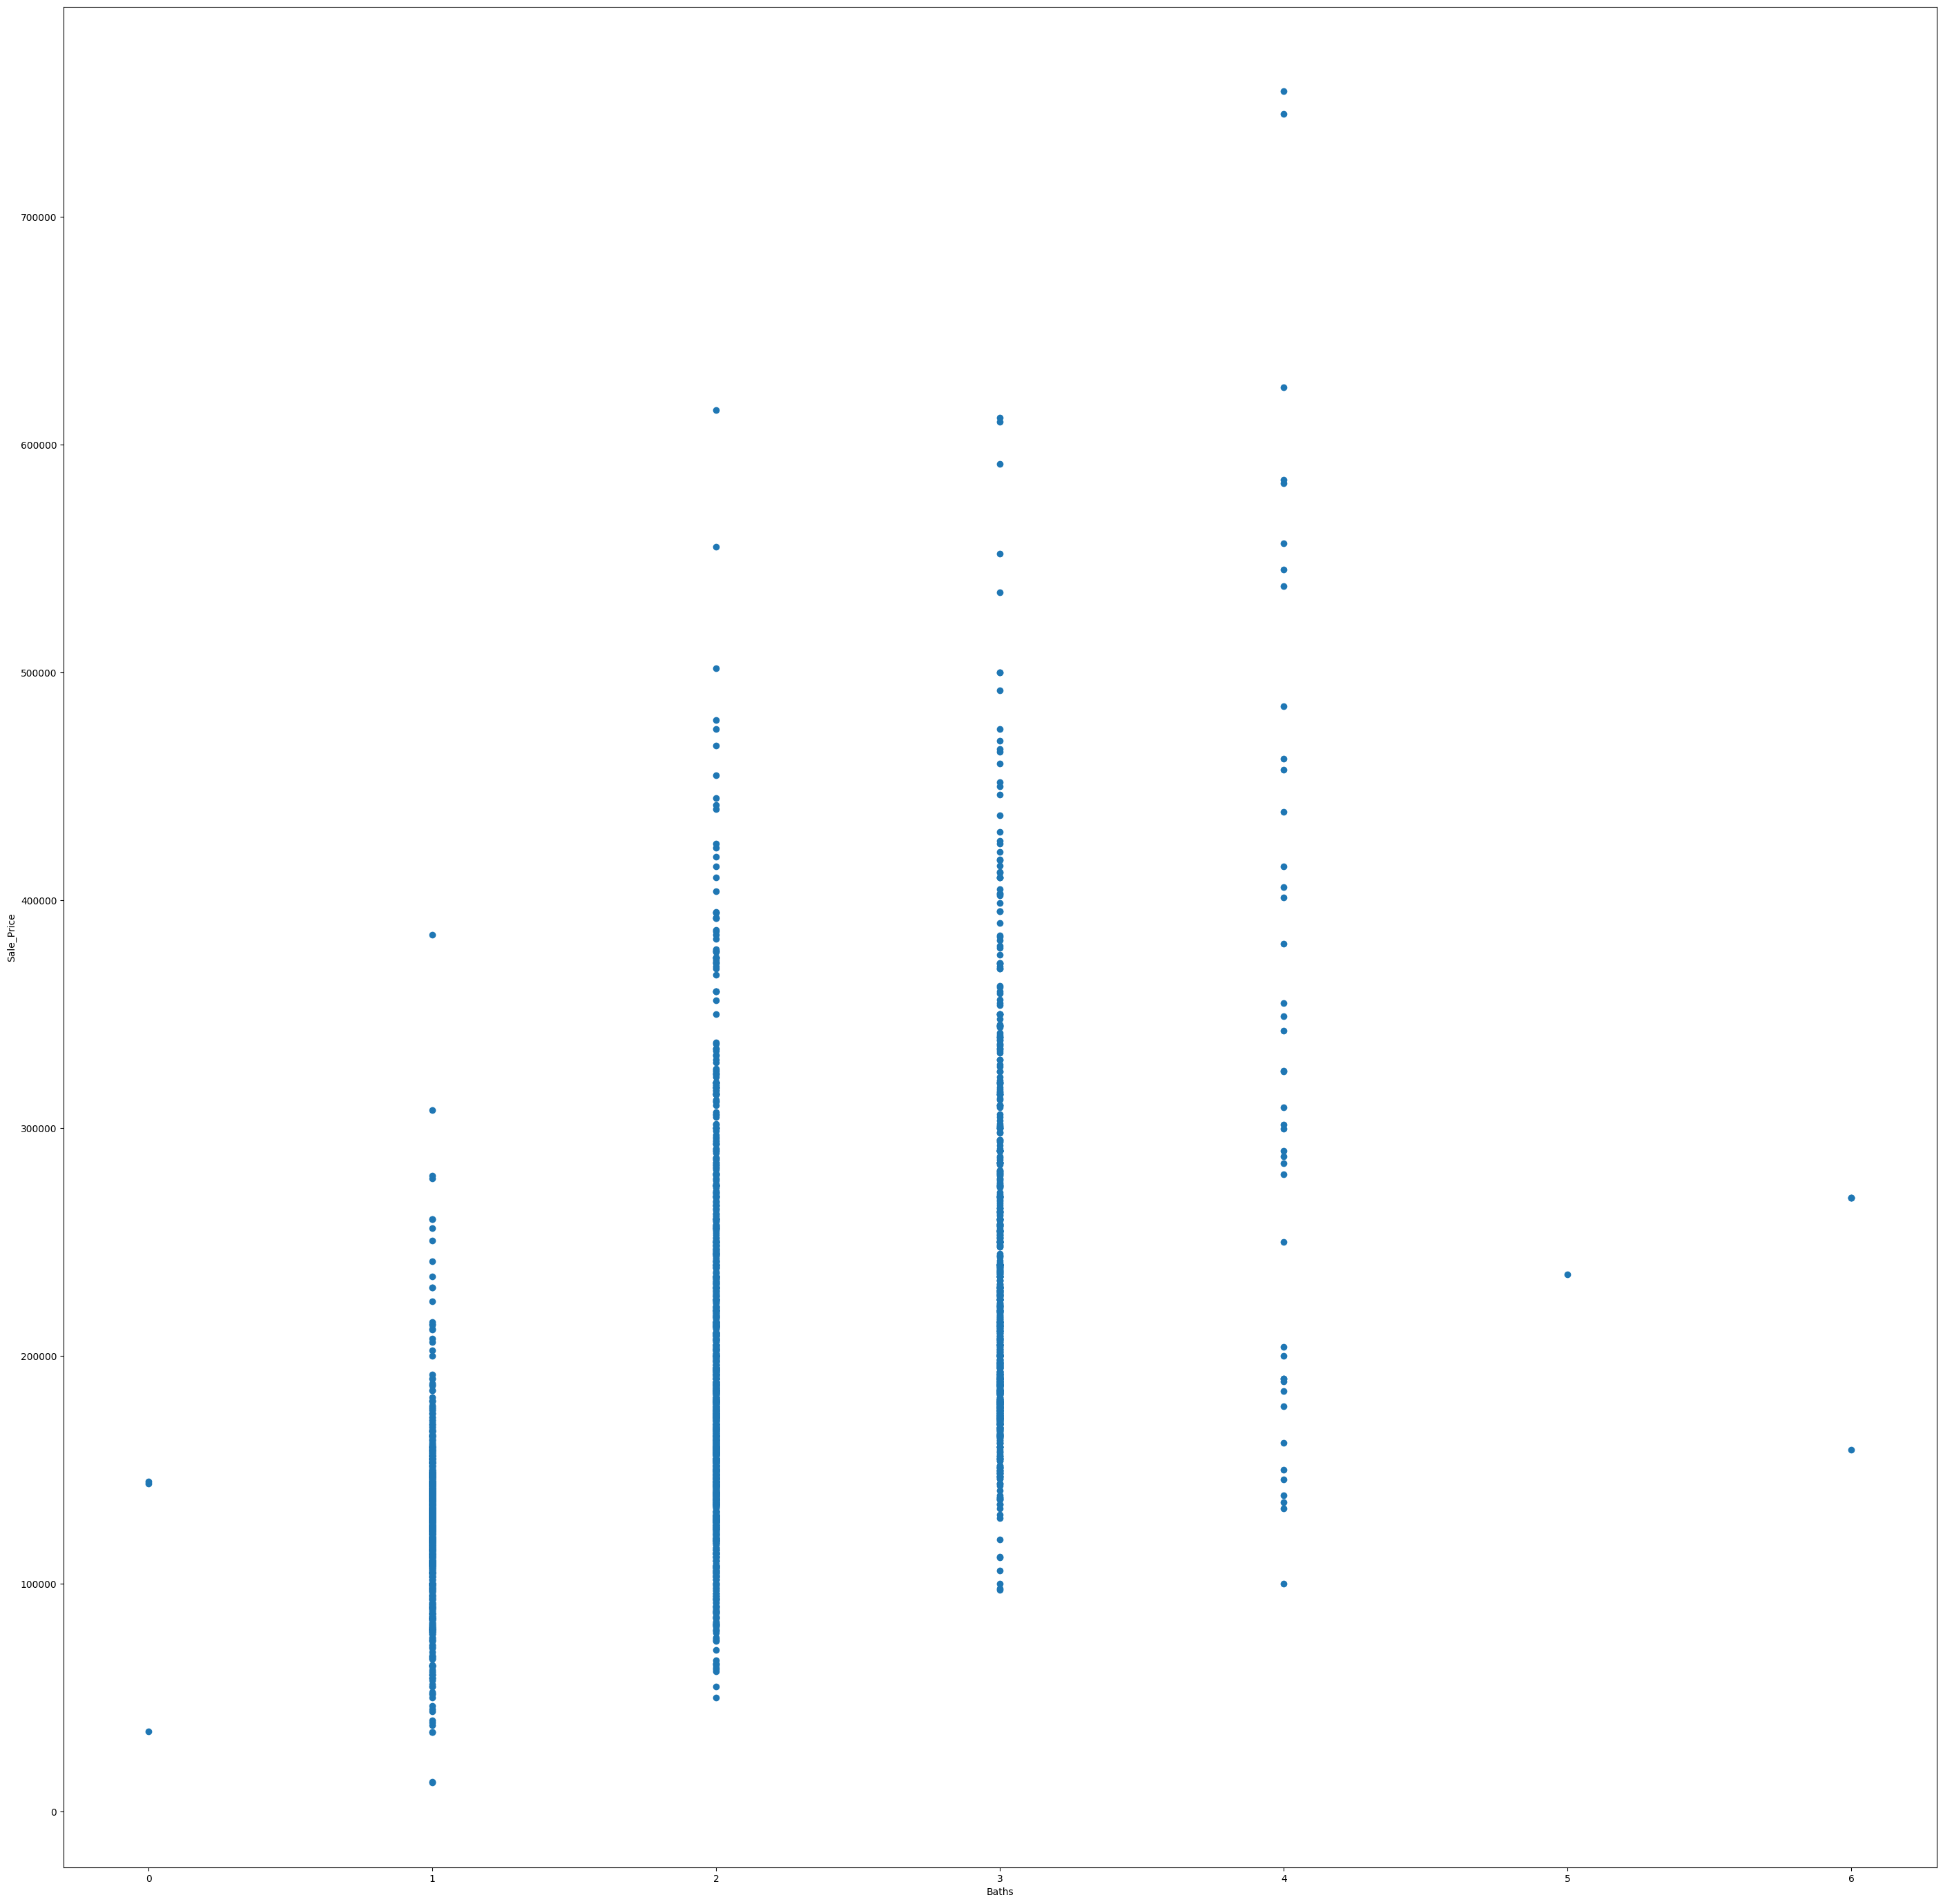

In [38]:
fig, ax = plt.subplots()
ax.scatter(temp_df['Baths'], df_features['Sale_Price'])
plt.xlabel('Baths')
plt.ylabel('Sale_Price')

Questo grafico comunica che abitazioni con solo un bagno non superano mai la soglia dei 400000$ e che case con almeno due bagni hanno un prezzo superiore rispetto alle case con un solo bagno.

Si può quindi concludere che la quantità di bagni va a inficiare sul prezzo delle abitazioni.

Ad ogni modo, come per i bagni del seminterrato, si è deciso di togliere `Full_Bath` e `Half_Bath`.

In [39]:
df_features = df_features.drop(columns = ['Full_Bath', 'Half_Bath'] , axis = 1)

Concatenazione dei due dataframe:

In [40]:
df_features = pd.concat([df_features, temp_df ], axis= 1)

Si verifica se il numero di colonne è effettivamente cambiato.

In [41]:
df_features.shape

(2930, 76)

<div class="alert alert-block alert-info" align = "center">
    <h1>Superficie totale dell'abitazione</h1>
</div>

Ragionamento analogo per il calcolo della superficie totale dell'abitazione.

In [42]:
def Total_SF_Floors(dataframe):
    
    # Dataframe temporaneo
    temp_df = pd.DataFrame(dataframe, columns = ['Total_SF_Floors'])
    # k rappresenta l'indice delle righe della nuova colonna
    k = 0
    for i, v in zip(dataframe['First_Flr_SF'], dataframe['Second_Flr_SF']):
        # Somma della superficie del primo e del secondo piano
        temp_df['Total_SF_Floors'][k] = i + v
        k += 1
        
    return temp_df

In [43]:
temp_df = Total_SF_Floors(df_features)

 Ora si analizza la relazione tra `Total_SF_Floors` e `Sale_Price`.

Text(0, 0.5, 'Sale_Price')

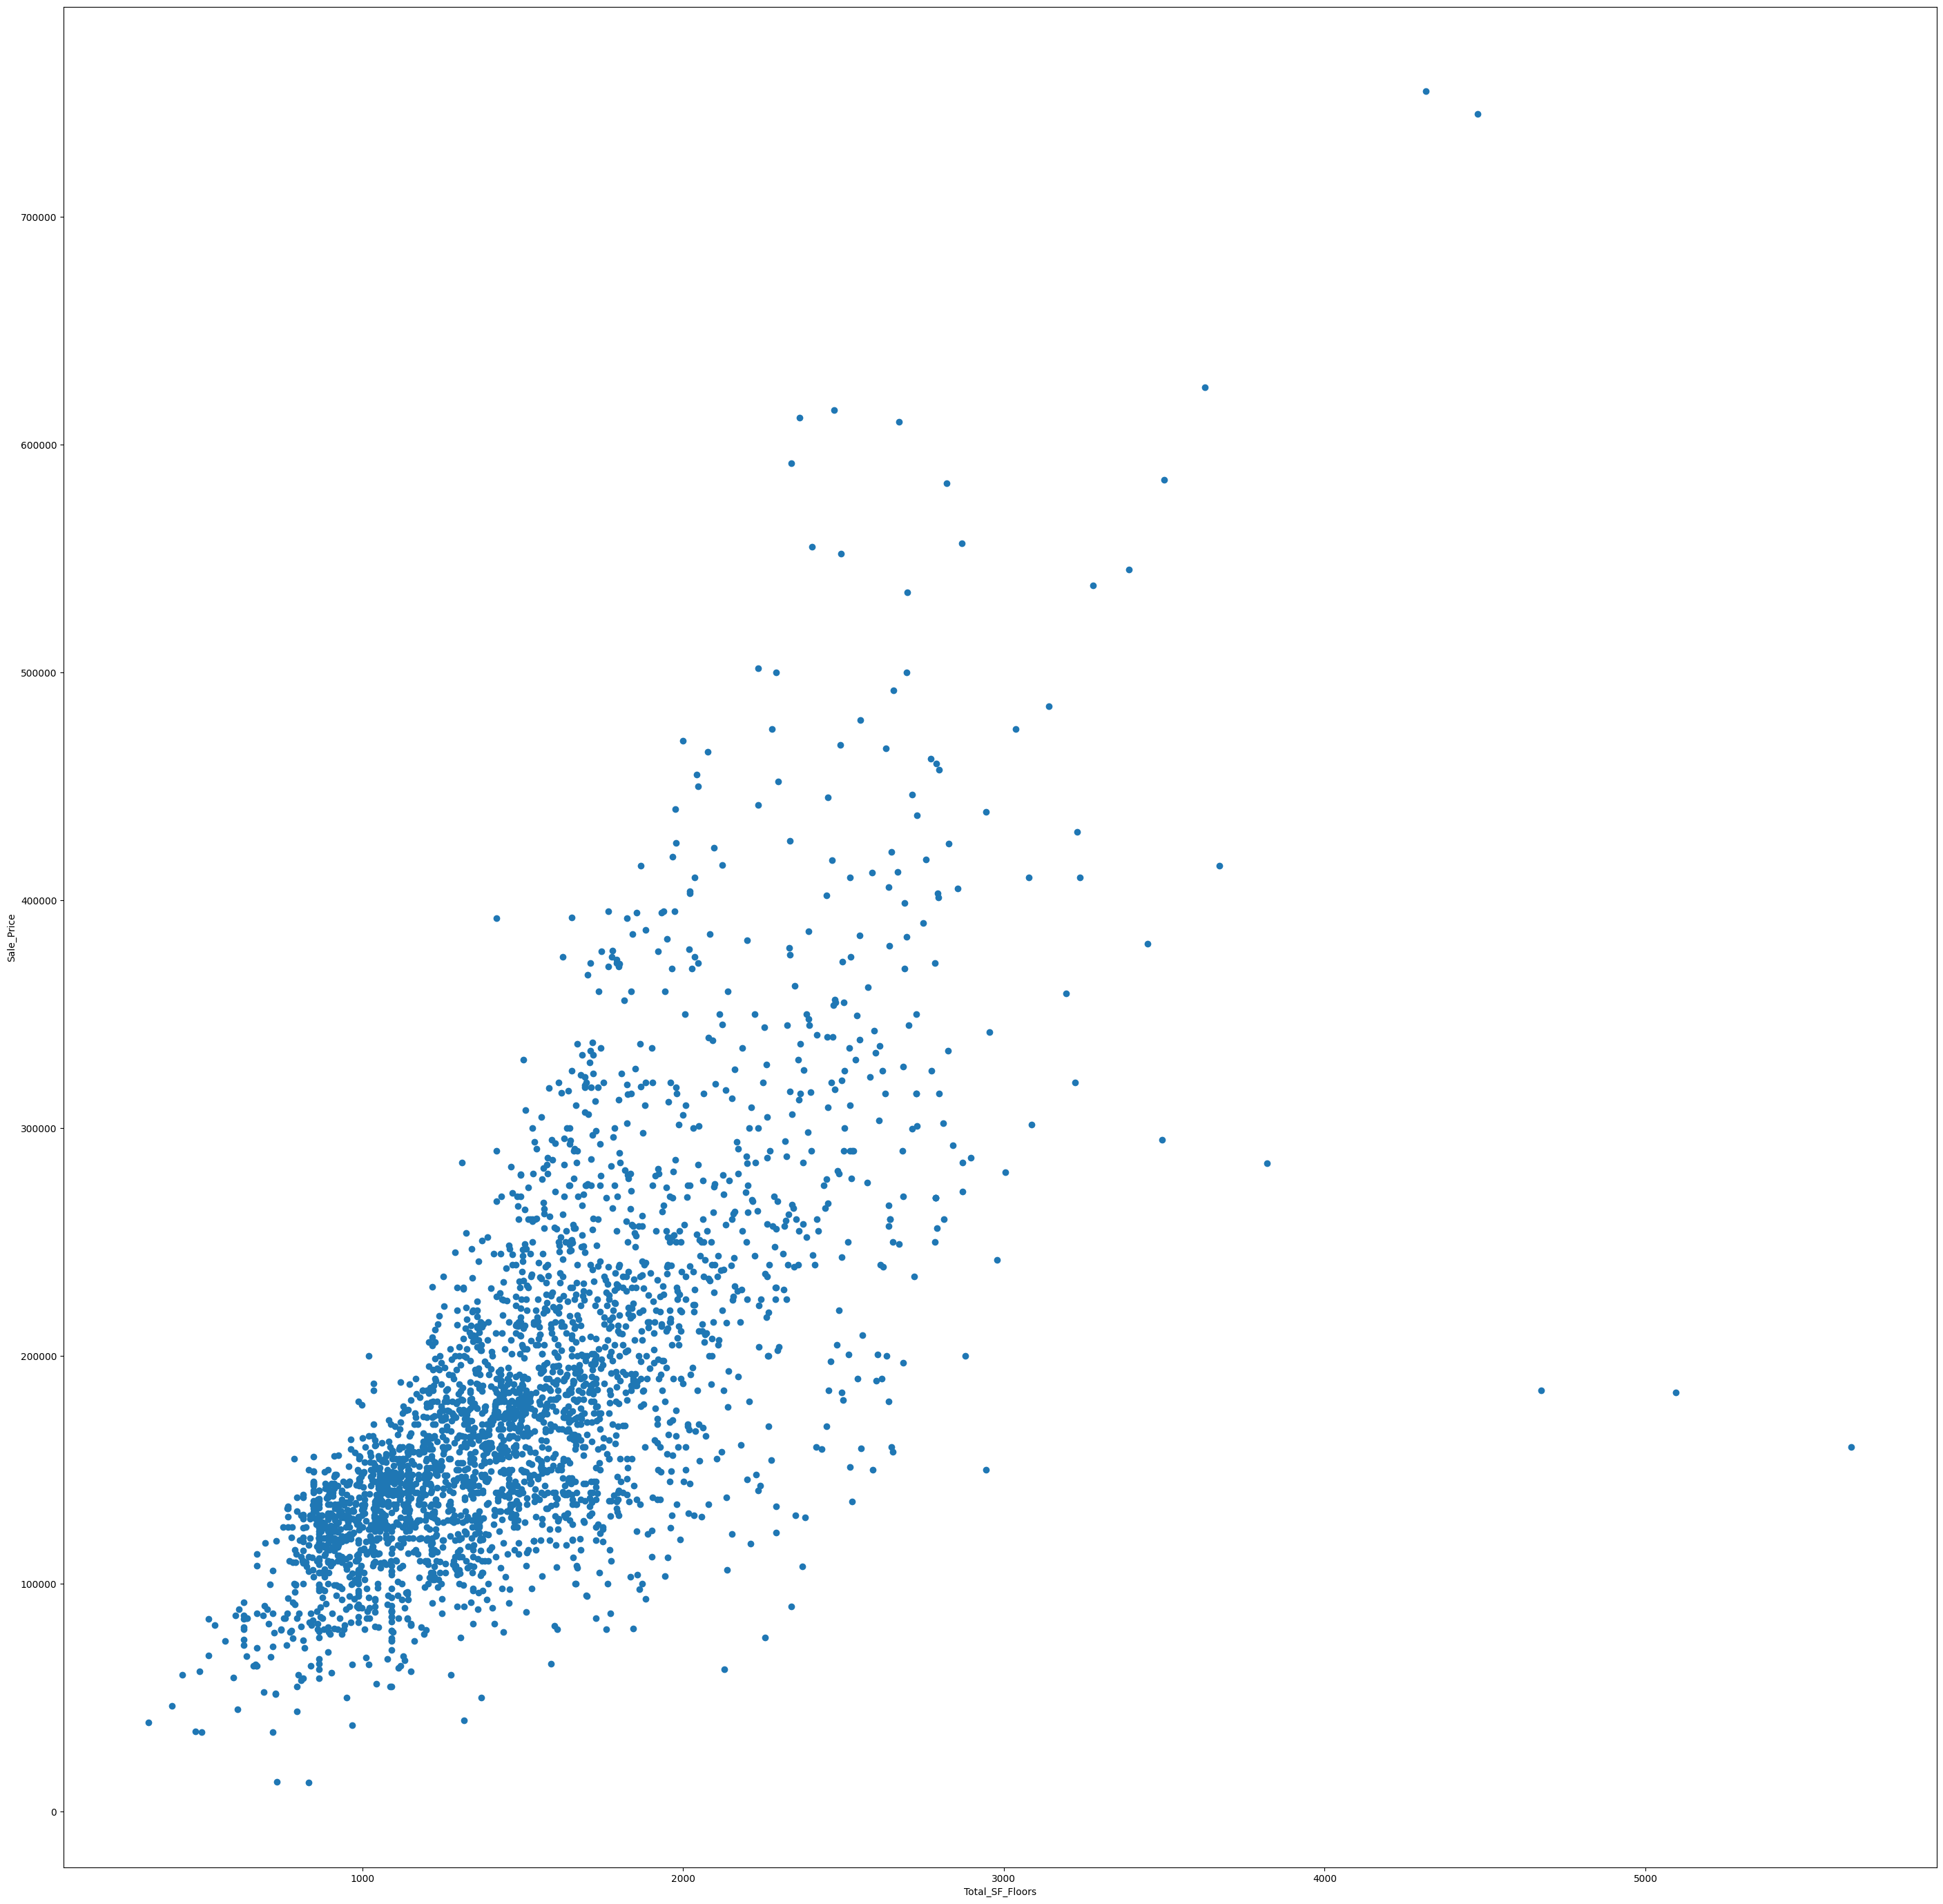

In [44]:
fig, ax = plt.subplots()
ax.scatter(temp_df['Total_SF_Floors'], df_features['Sale_Price'])
plt.xlabel('Total_SF_Floors')
plt.ylabel('Sale_Price')

Nonostante vi sia una grande dispersione rispetto alla retta principale del grafico si può intuire un andamento lineare: abitazioni la cui superficie è piccola costano meno, mentre abitazioni la cui superficie è grande costano di più.

Per questo motivo si introduce anche questa feature nel dataset.

Concatenazione dei due dataframe:

In [45]:
df_features = pd.concat([df_features, temp_df ], axis= 1)

Si verifica se il numero di colonne è effettivamente cambiato.

In [46]:
df_features.shape

(2930, 77)

Si ripresenta la heatmap.

C:\Users\Serena\AppData\Local\Temp\ipykernel_8948\2192487877.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  g = sns.heatmap(df_features.corr(),annot=True, fmt = ".1f")


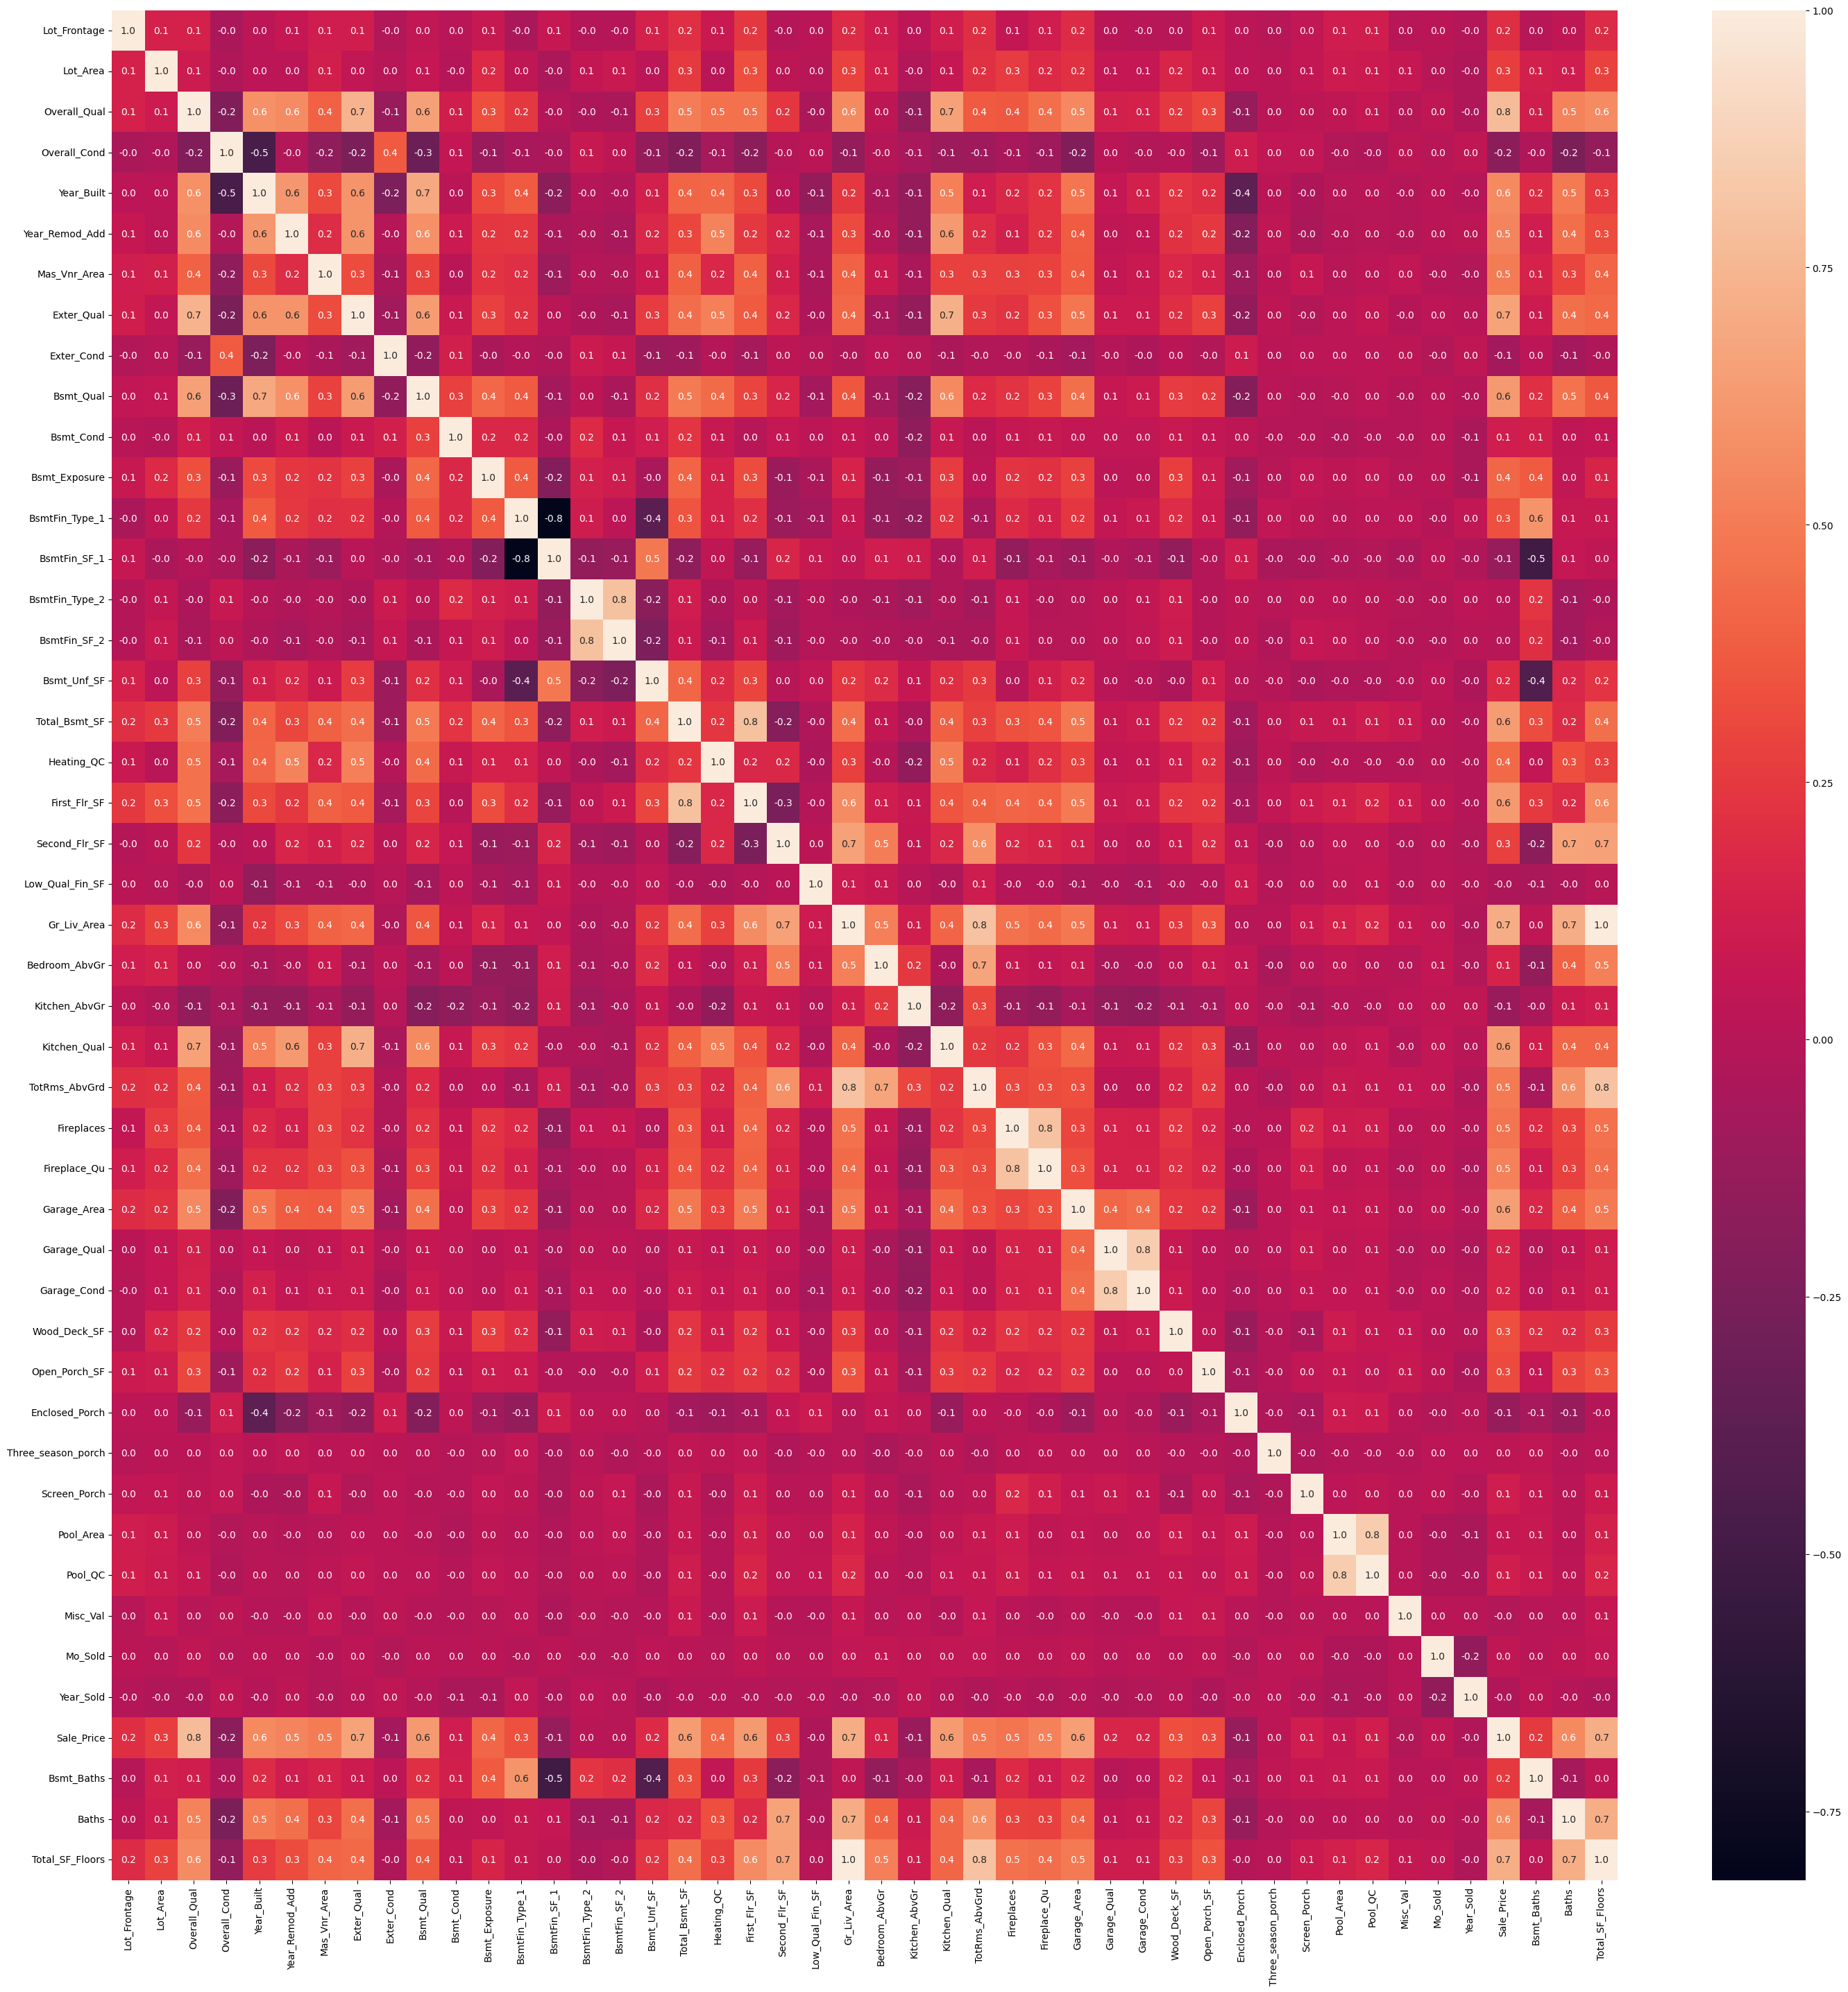

In [47]:
plt.rcParams['figure.figsize']=35,35
g = sns.heatmap(df_features.corr(),annot=True, fmt = ".1f")

Si nota qualcosa di interessante:

- La nuova feature aggiunta (`Total_SF_Floors`) e `Gr_Liv_Area` hanno una correlazione molto forte, questo perché probabilmente molte case hanno un solo piano.

Di seguito si mostra un grafico per mettere a confronto queste due feature.

Text(0, 0.5, 'Gr_Liv_Area')

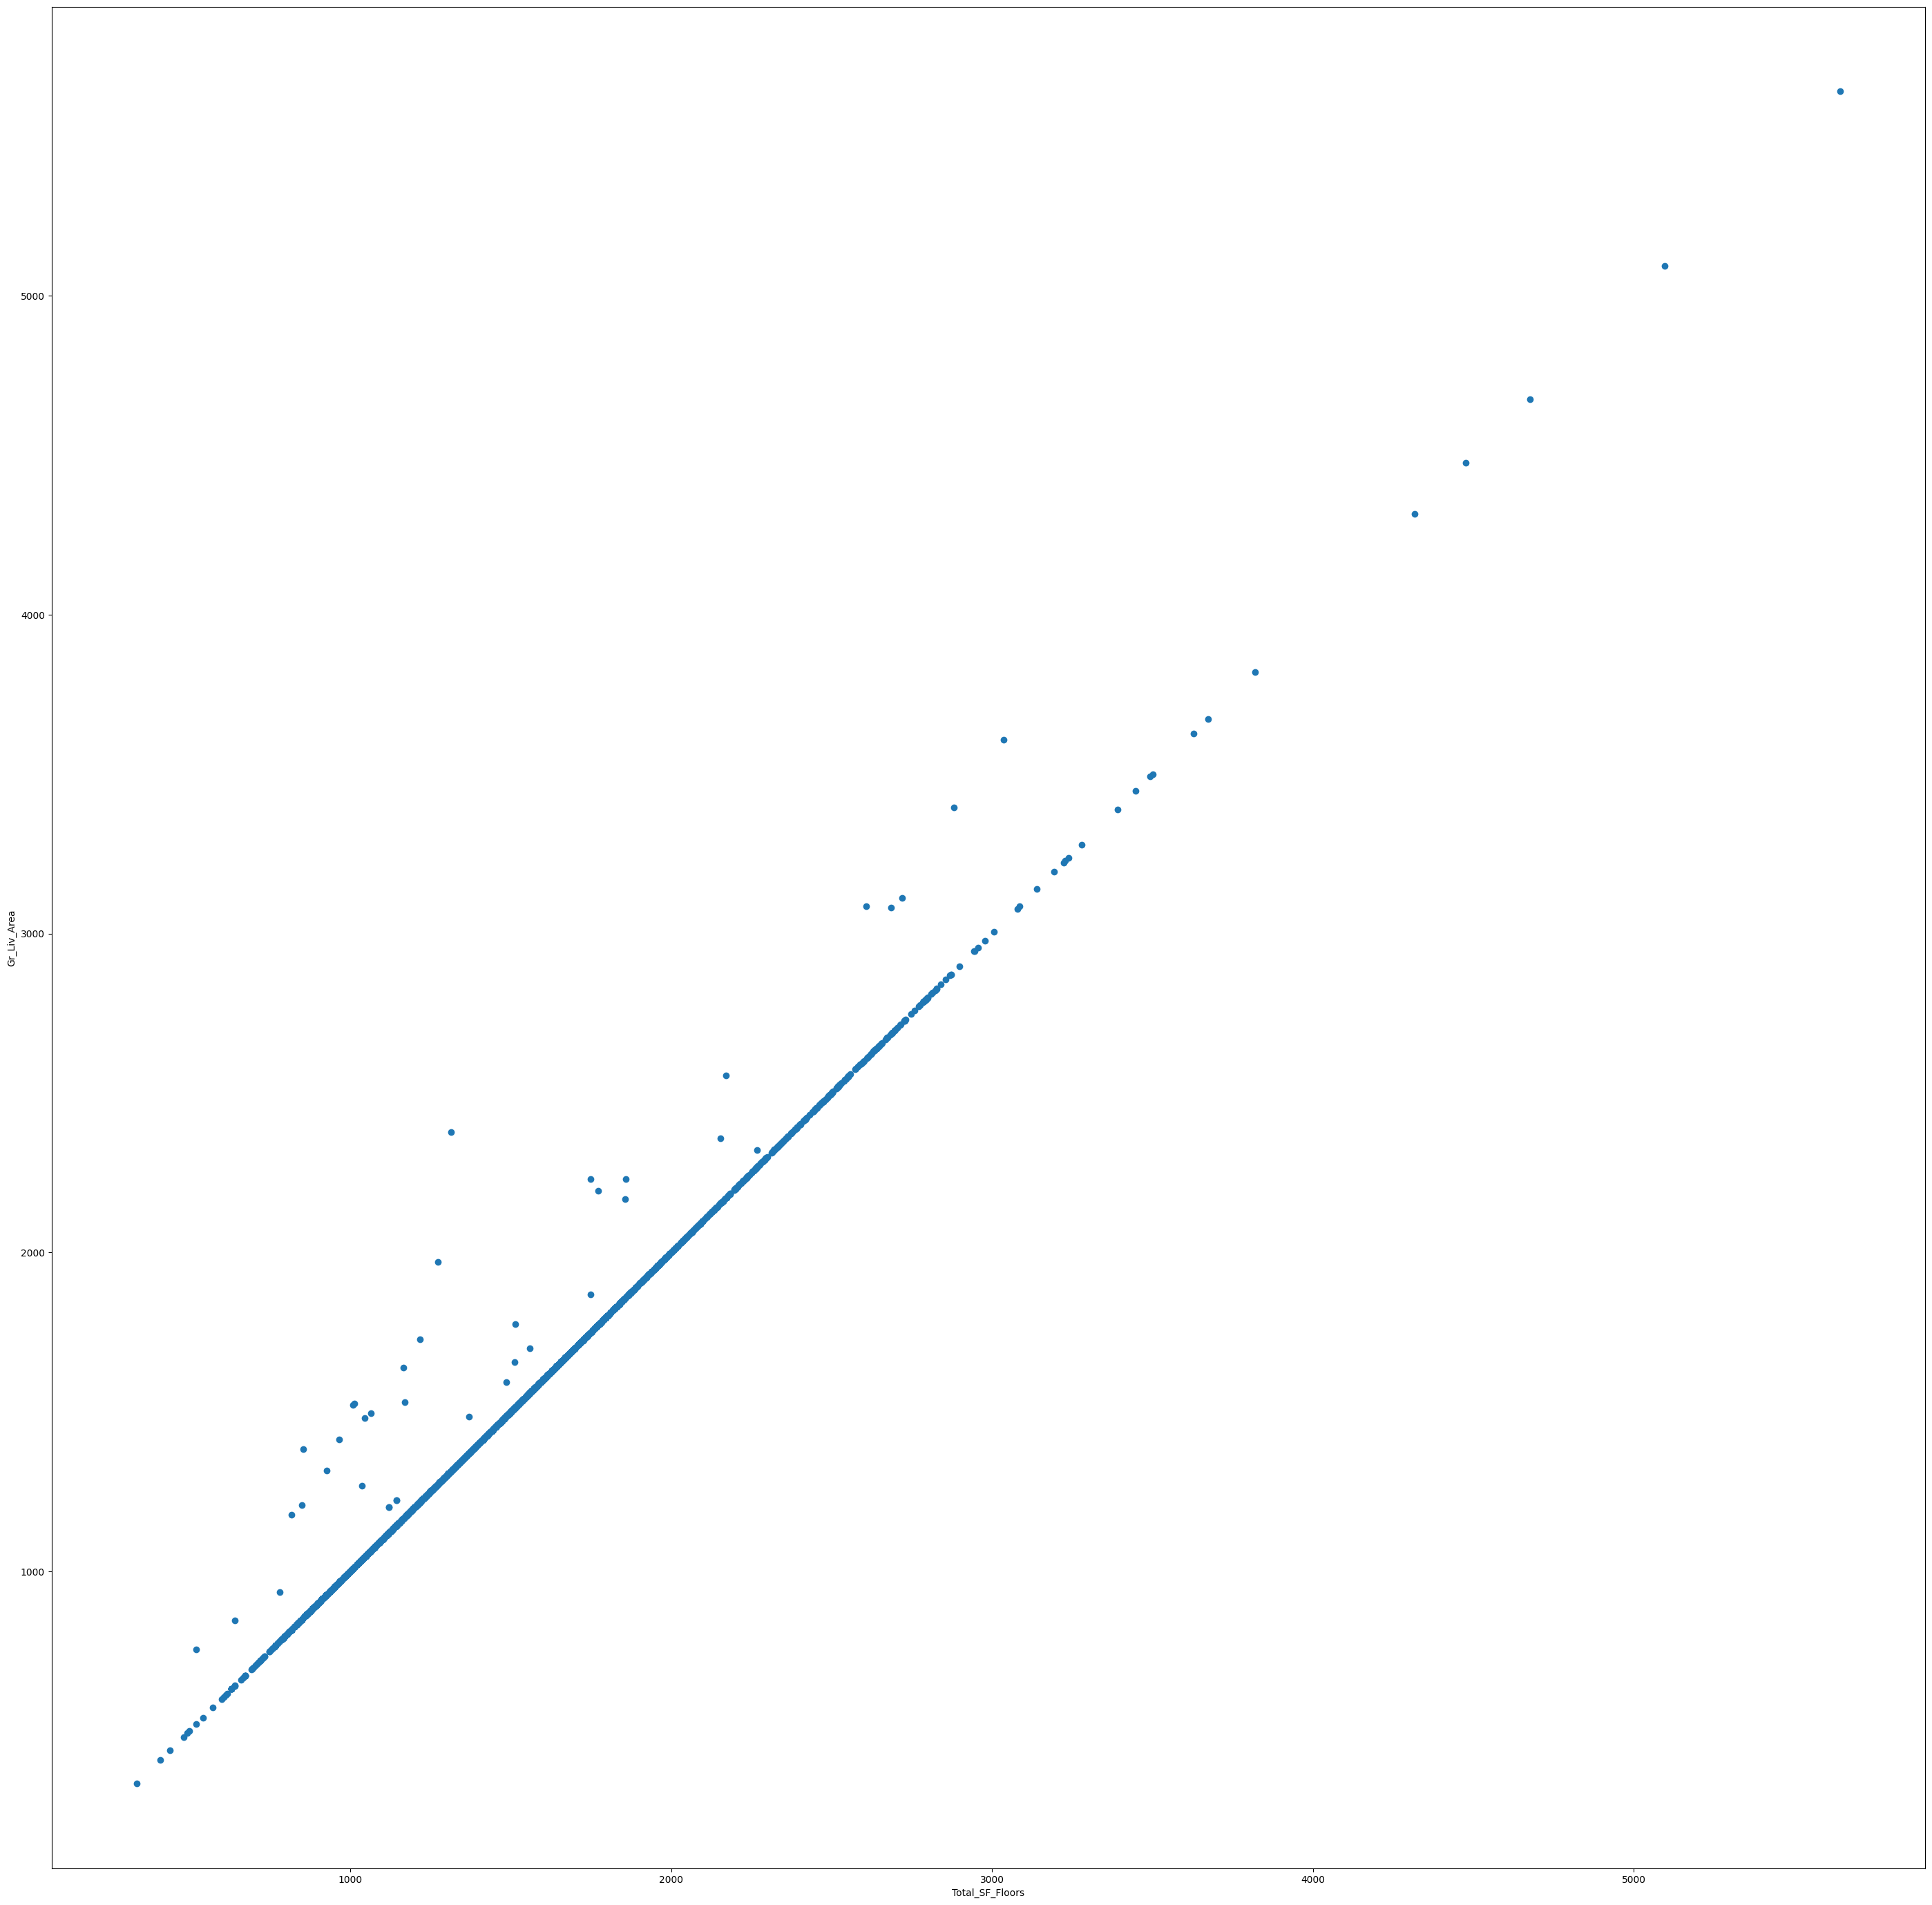

In [48]:
fig, ax = plt.subplots()
ax.scatter(df_features['Total_SF_Floors'], df_features['Gr_Liv_Area'])
plt.xlabel('Total_SF_Floors')
plt.ylabel('Gr_Liv_Area')

Come si era presupposto, dal grafico si evince che quasi tutte le abitazioni hanno un solo piano.

Per questo verrà eliminata la feature `Gr_Liv_Area`.

In [49]:
df_features = df_features.drop(columns = ['Gr_Liv_Area'] , axis = 1)

Si verifica se il numero di colonne è effettivamente cambiato.

In [50]:
df_features.shape

(2930, 76)

<div class="alert alert-block alert-info" align = "center">
    <h1>Presenza di piscine</h1>
</div>

Si osserva ora la feature `Pool_QC` che indica la qualità delle piscine (se) presenti nell'abitazione.

In [51]:
df_features['Pool_QC'].value_counts()

0    2917
4       4
3       4
1       3
2       2
Name: Pool_QC, dtype: int64

Si può notare che la stra grande maggioranza delle abitazioni non ha nemmeno una piscina.

Quindi, si è deciso di aggiungere una nuova colonna `Pool_Presence` che contiene la presenza di eventuali piscine nell'abitazione: 
- Il valore della feature è settato a 1 se è presente almeno una piscina;
- Il valore della feature è settato a 0 se non sono presenti piscine.

In [52]:
def Pool_YN(dataframe):
    
    # Dataframe temporaneo
    temp_df = pd.DataFrame(dataframe, columns = ['Pool_Presence'])
    # k rappresenta l'indice delle righe della nuova colonna
    k = 0
    for i in range(len(dataframe['Pool_QC'])):
        # Se è presente almeno una piscina si imposta la feature a 1
        if (dataframe['Pool_QC'][i] == 0):
            temp_df['Pool_Presence'][k] = 0
        # Se non è presente nemmeno una piscina si imposta la feature a 0
        else:
            temp_df['Pool_Presence'][k] = 1
        k += 1
    return temp_df

In [53]:
temp_df = Pool_YN(df_features)

Si verifica la relazione tra `Sale_Price` e `Pool_Presence`.

Text(0, 0.5, 'Sale_Price')

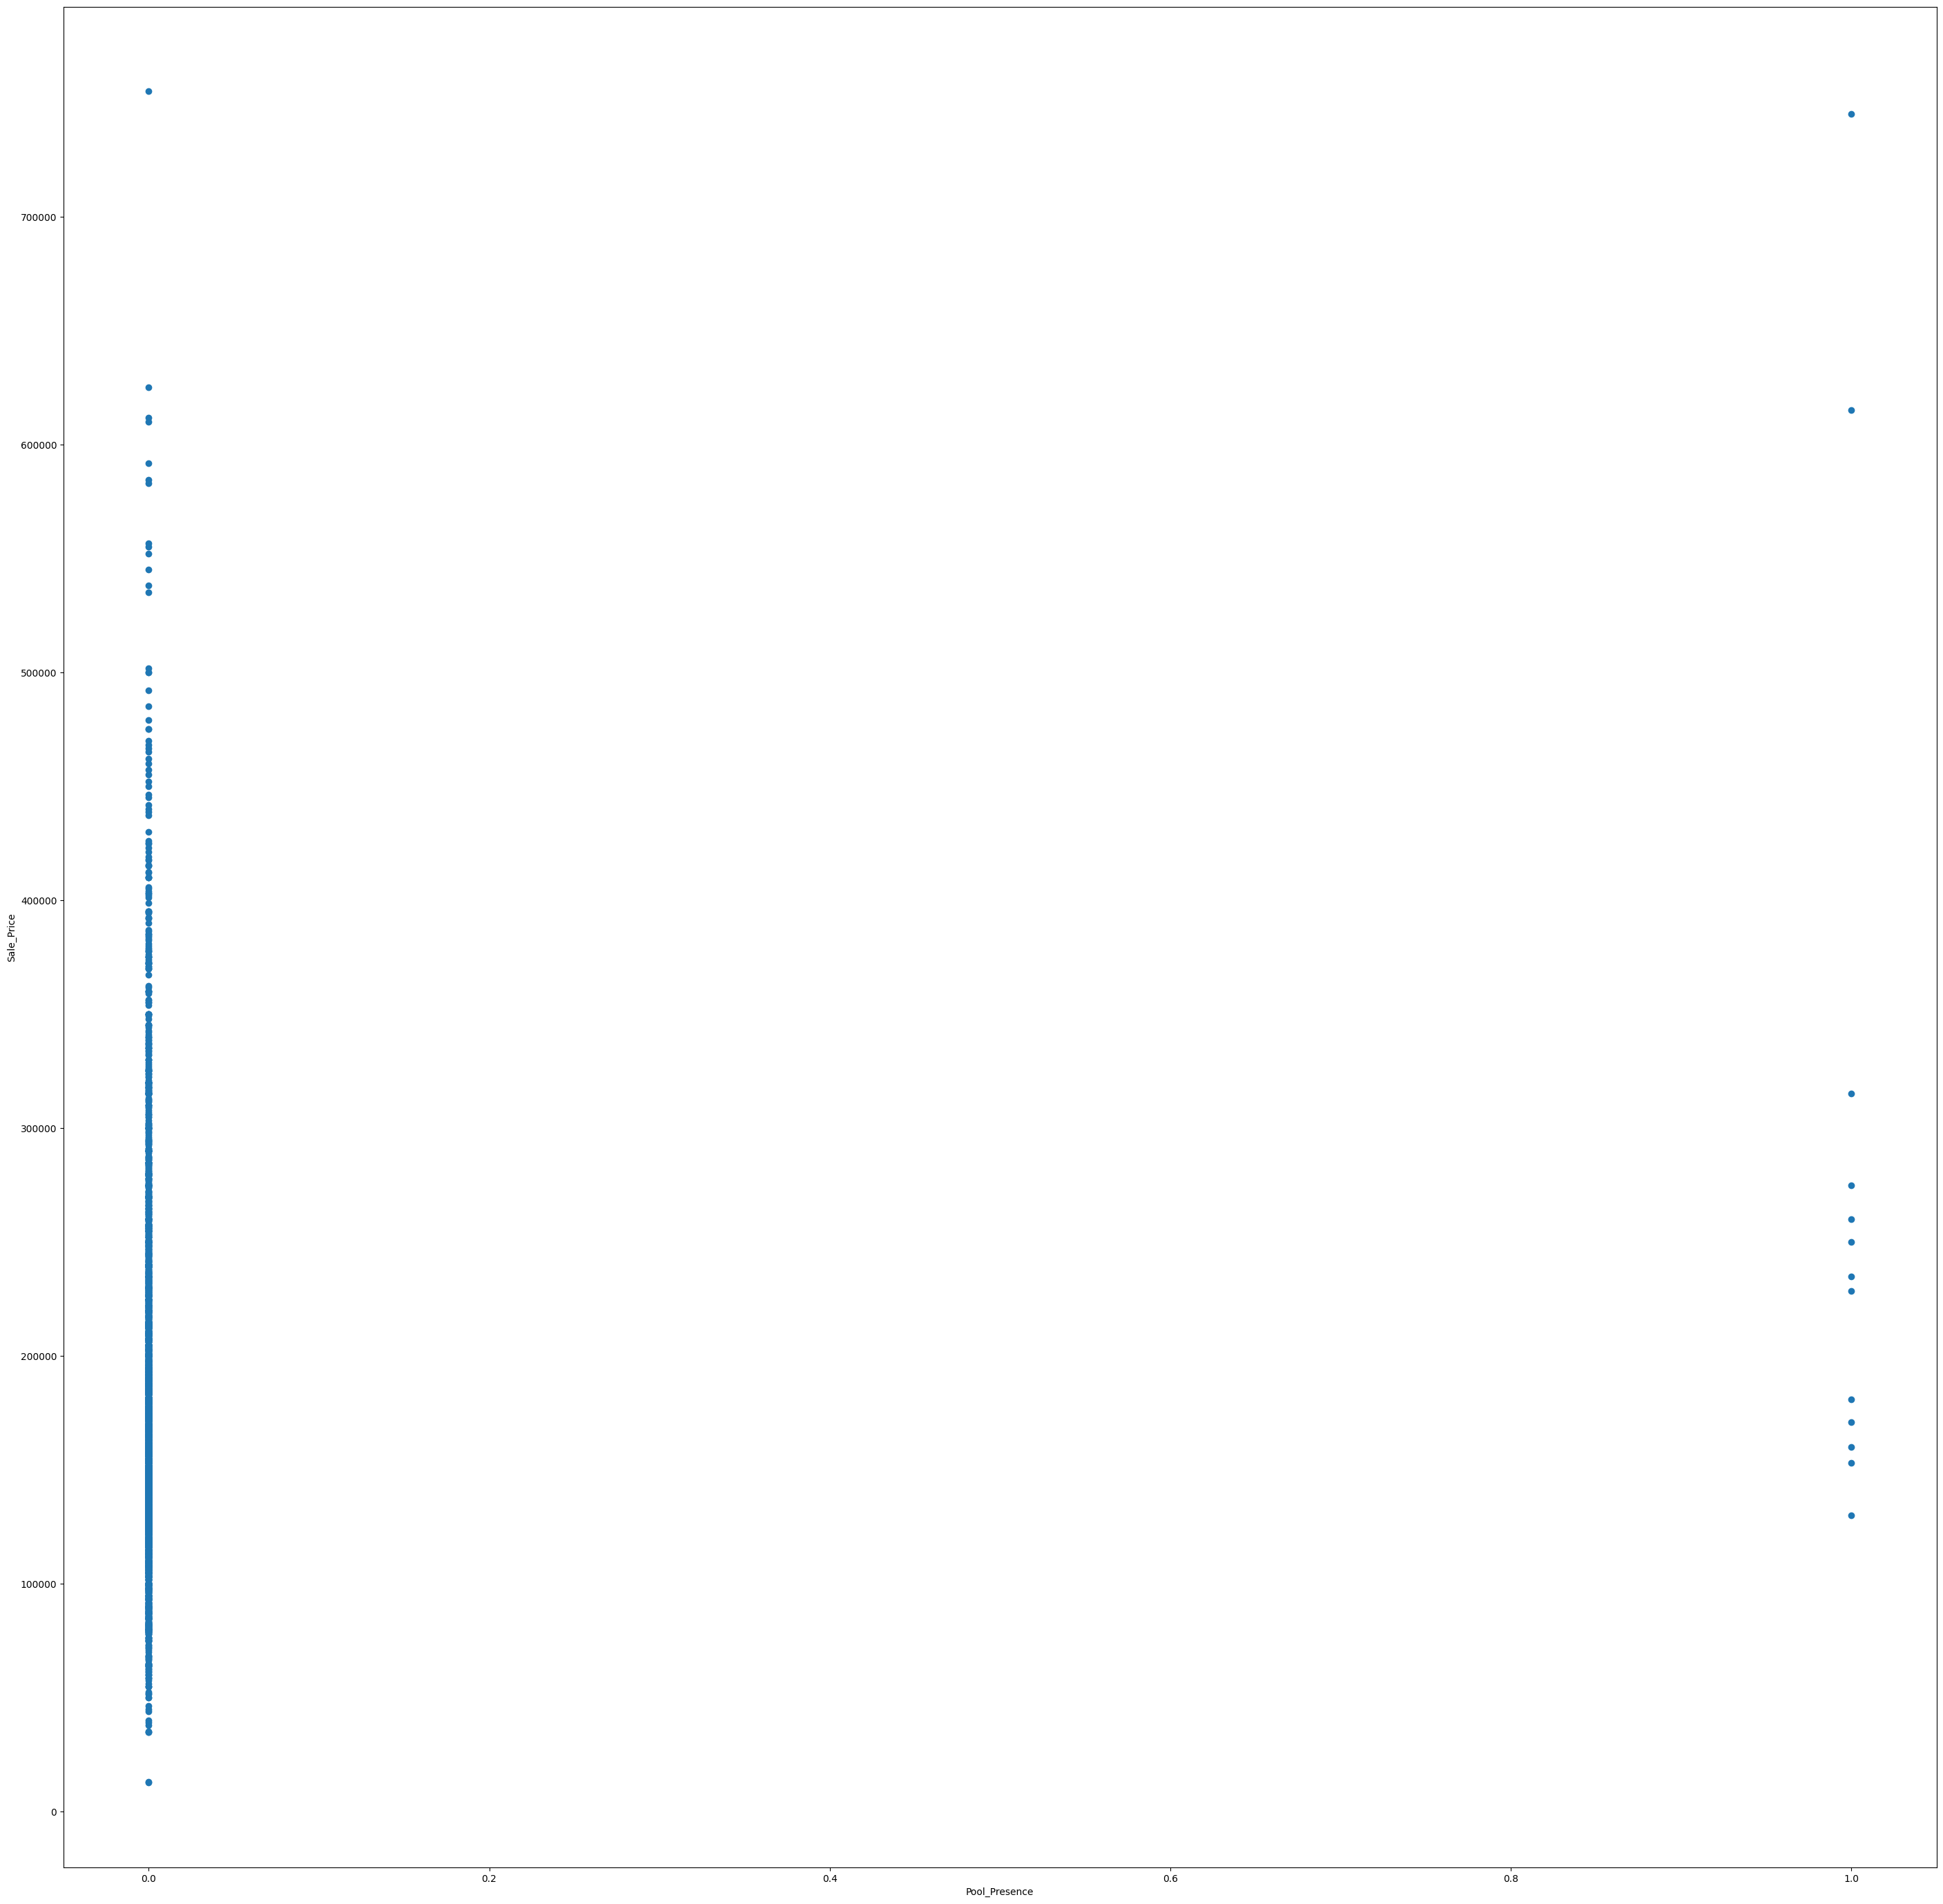

In [54]:
fig, ax = plt.subplots()
ax.scatter(temp_df['Pool_Presence'], df_features['Sale_Price'])
plt.xlabel('Pool_Presence')
plt.ylabel('Sale_Price')

Dal grafico si nota come la presenza delle piscine non vada a inficiare in modo consistente il prezzo dell'abitazione (poche abitazioni hanno una piscina perciò a priori non può essere una feature discriminante).

Per cui al posto di tenere due colonne quali `Pool_QC` e `Pool_Area` si mantiene la nuova colonna `Pool_Presence` che indica solo la presenza di piscine (se ve ne sono).

Concatenazione dei due dataframe:

In [55]:
df_features = pd.concat([df_features, temp_df ], axis= 1)

Si droppa ora `Pool_QC` e  `Pool_Area`.

In [56]:
df_features = df_features.drop(columns = ['Pool_QC', 'Pool_Area'] , axis = 1)

Si verifica se il numero di colonne è effettivamente cambiato.

In [57]:
df_features.shape

(2930, 75)

<div class="alert alert-block alert-info" align = "center">
    <h1>Presenza e area del porticato</h1>
</div>

Procedimento analogo per i porticati dell'abitazione ma si aggiunge una feature:
- Si vuole mantenere nel dataset l'informazione della presenza o meno di un porticato;
- Si crea una feature `Porch_Area` che contiene l'area del porticato.

Così facendo è possibile eliminare `Open_Porch_SF`, `Enclosed_Porch`, `Three_season_porch` e `Screen_Porch`, non mantendo quindi il tipo di portico.

In [58]:
def Porch_YN_Area(dataframe):
    
    n_rows, n_cols = dataframe.shape
    # Dataframe temporaneo
    temp_df = pd.DataFrame(dataframe, columns = ['Porch_Presence', 'Porch_Area'])
    # k rappresenta l'indice delle righe della nuova colonna
    k = 0
    for i in range(n_rows):
        # Se almeno uno dei valori non è 0, significa che l'abitazione ha un porticato
        if (dataframe['Open_Porch_SF'][i] != 0.0 or dataframe['Enclosed_Porch'][i] != 0.0 or dataframe['Three_season_porch'][i] != 0.0 or dataframe['Screen_Porch'][i] != 0.0):
            temp_df['Porch_Presence'][k] = 1
            temp_df['Porch_Area'][k] = float(dataframe['Open_Porch_SF'][i]) + float(dataframe['Enclosed_Porch'][i]) + float(dataframe['Three_season_porch'][i]) + float(dataframe['Screen_Porch'][i] == 0)
        # Se tutti i valori sono 0, significa che l'abitazione non ha un porticato
        else:
            temp_df['Porch_Presence'][k] = 0
            temp_df['Porch_Area'][k] = 0.0
        
        k += 1
    
    return temp_df

In [59]:
temp_df = Porch_YN_Area(df_features)

Si indaga sulla relazione tra il prezzo delle abitazioni e l'area dei porticati.

Text(0, 0.5, 'Sale_Price')

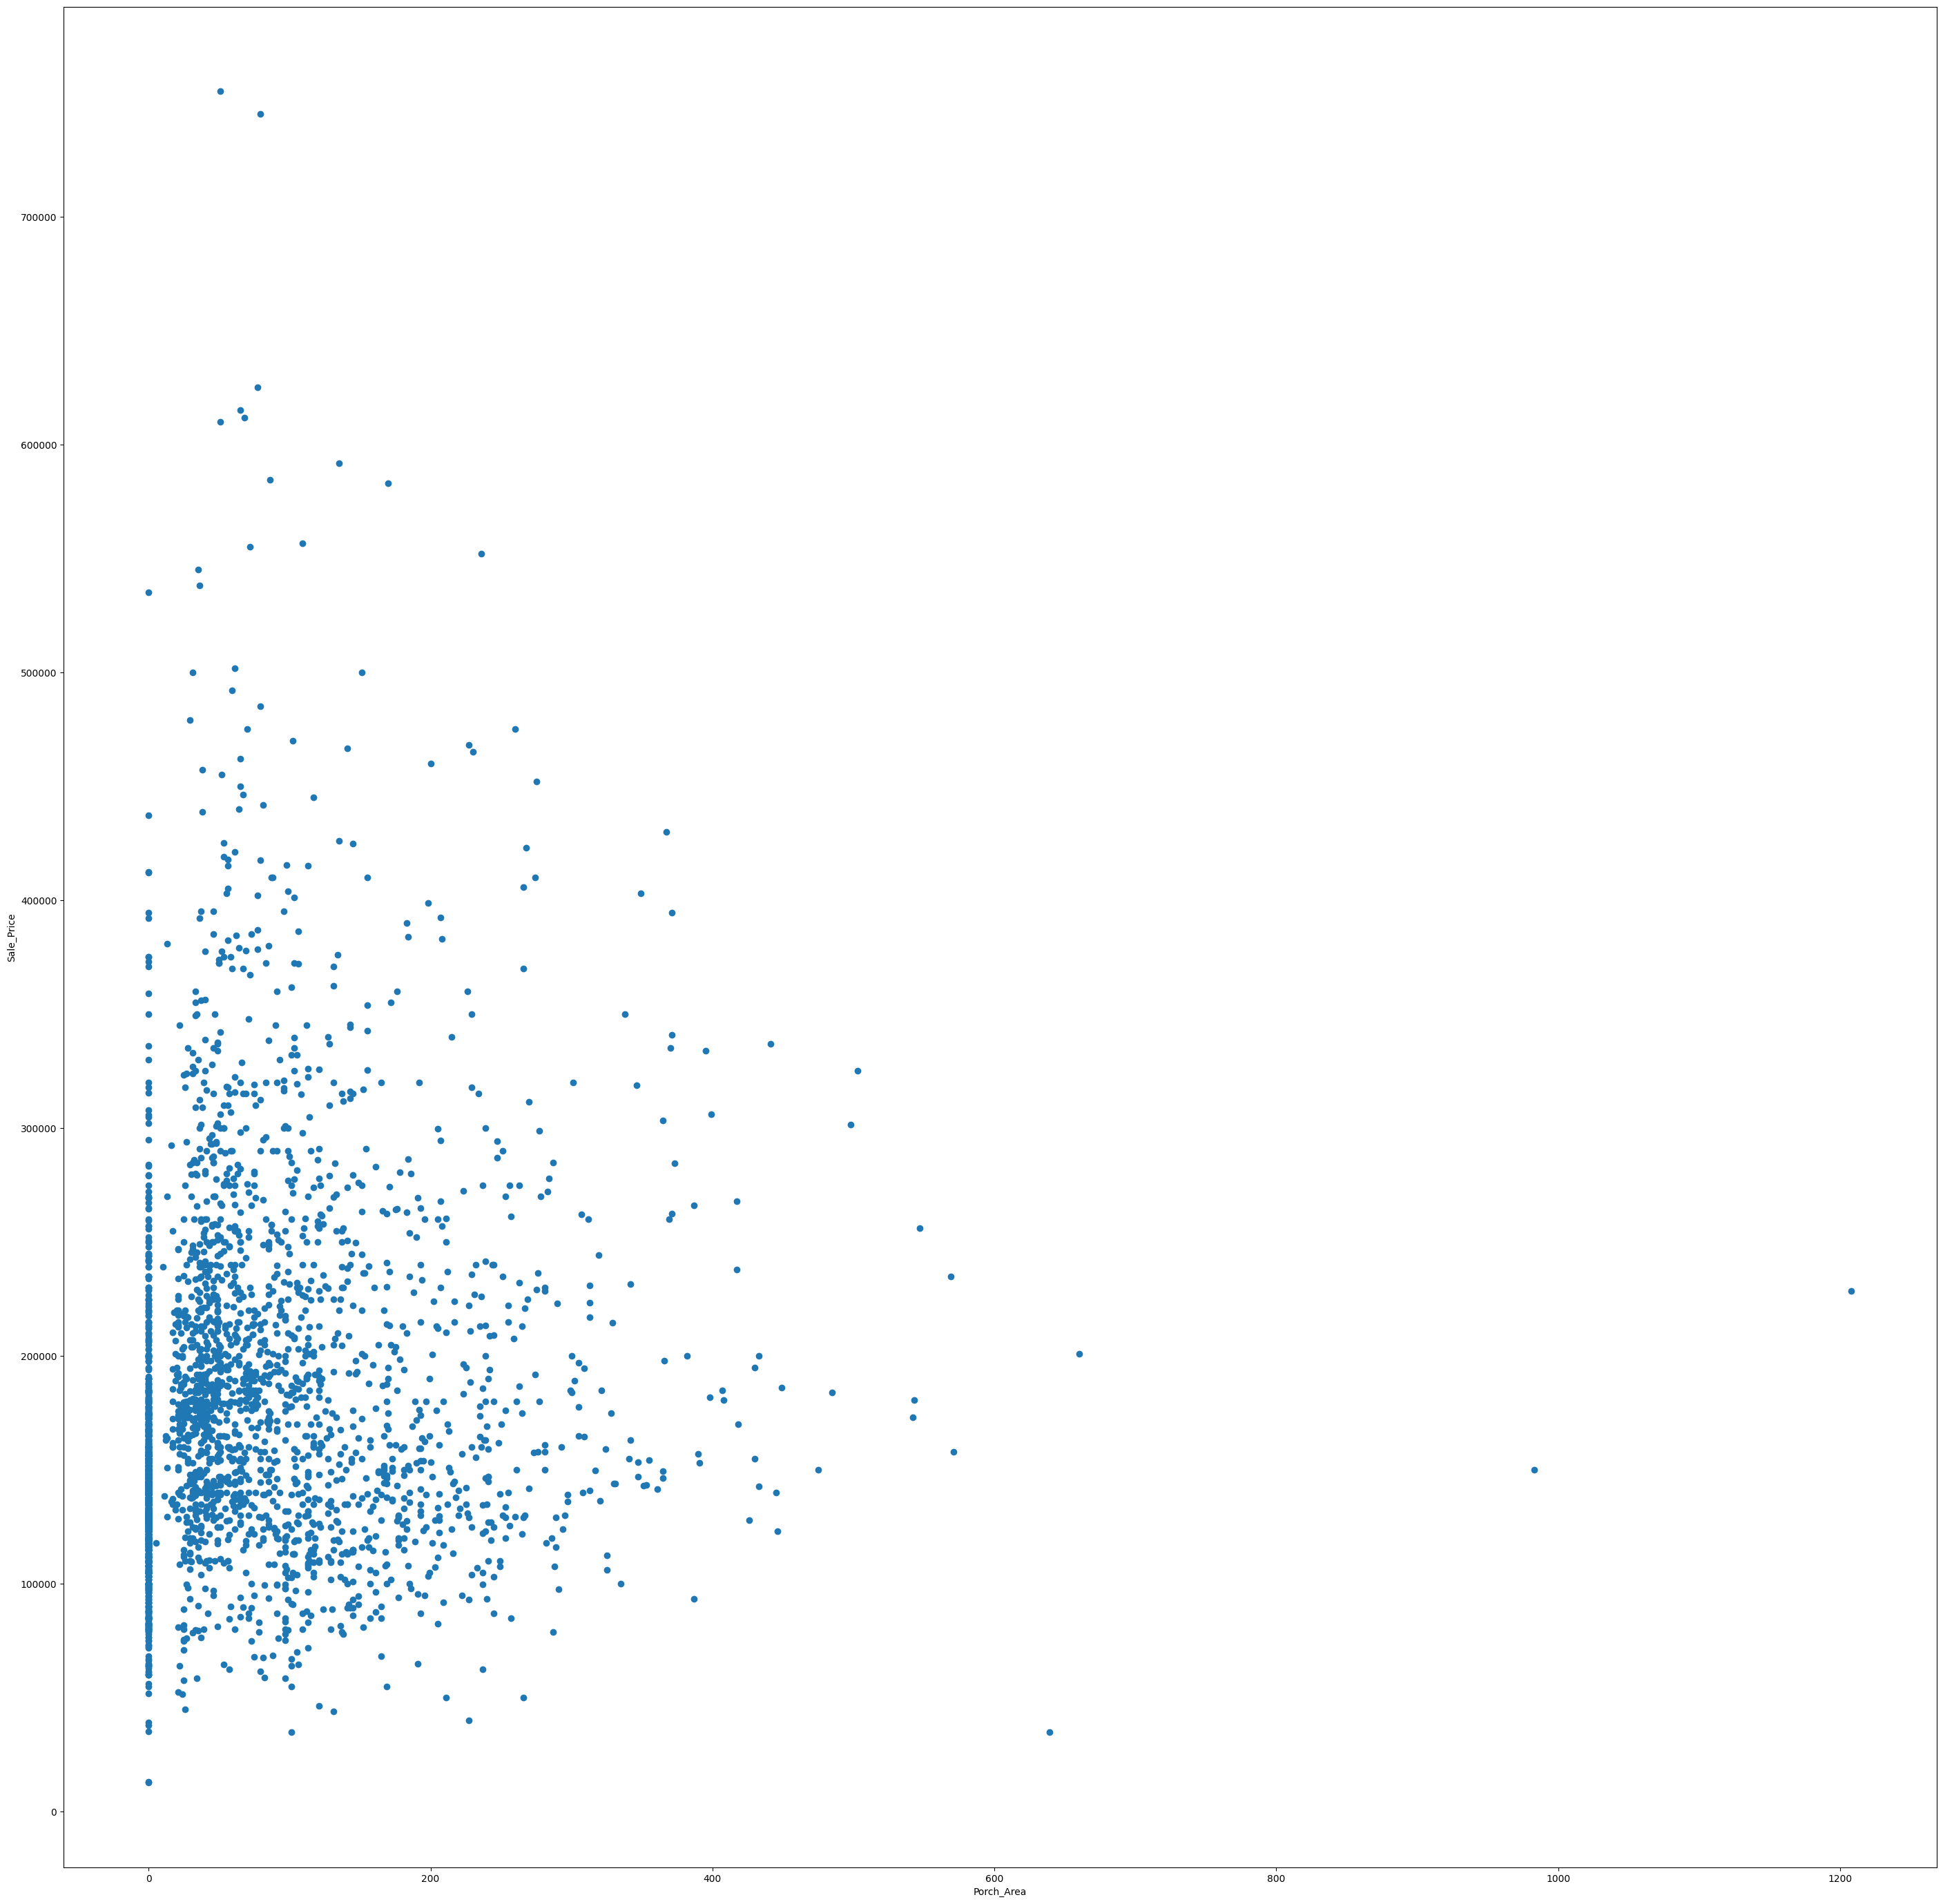

In [60]:
fig, ax = plt.subplots()
ax.scatter(temp_df['Porch_Area'], df_features['Sale_Price'])
plt.xlabel('Porch_Area')
plt.ylabel('Sale_Price')

La relazione non sembra lineare eppure si può notare che a porticati di piccole dimensioni corrispondano prezzi bassi e a porticati di grandi dimensioni corrispondano prezzi alti. 

Si verifica la presenza di un'eventuale relazione tra `Sale_Price` e `Porch_Presence`.

Text(0, 0.5, 'Sale_Price')

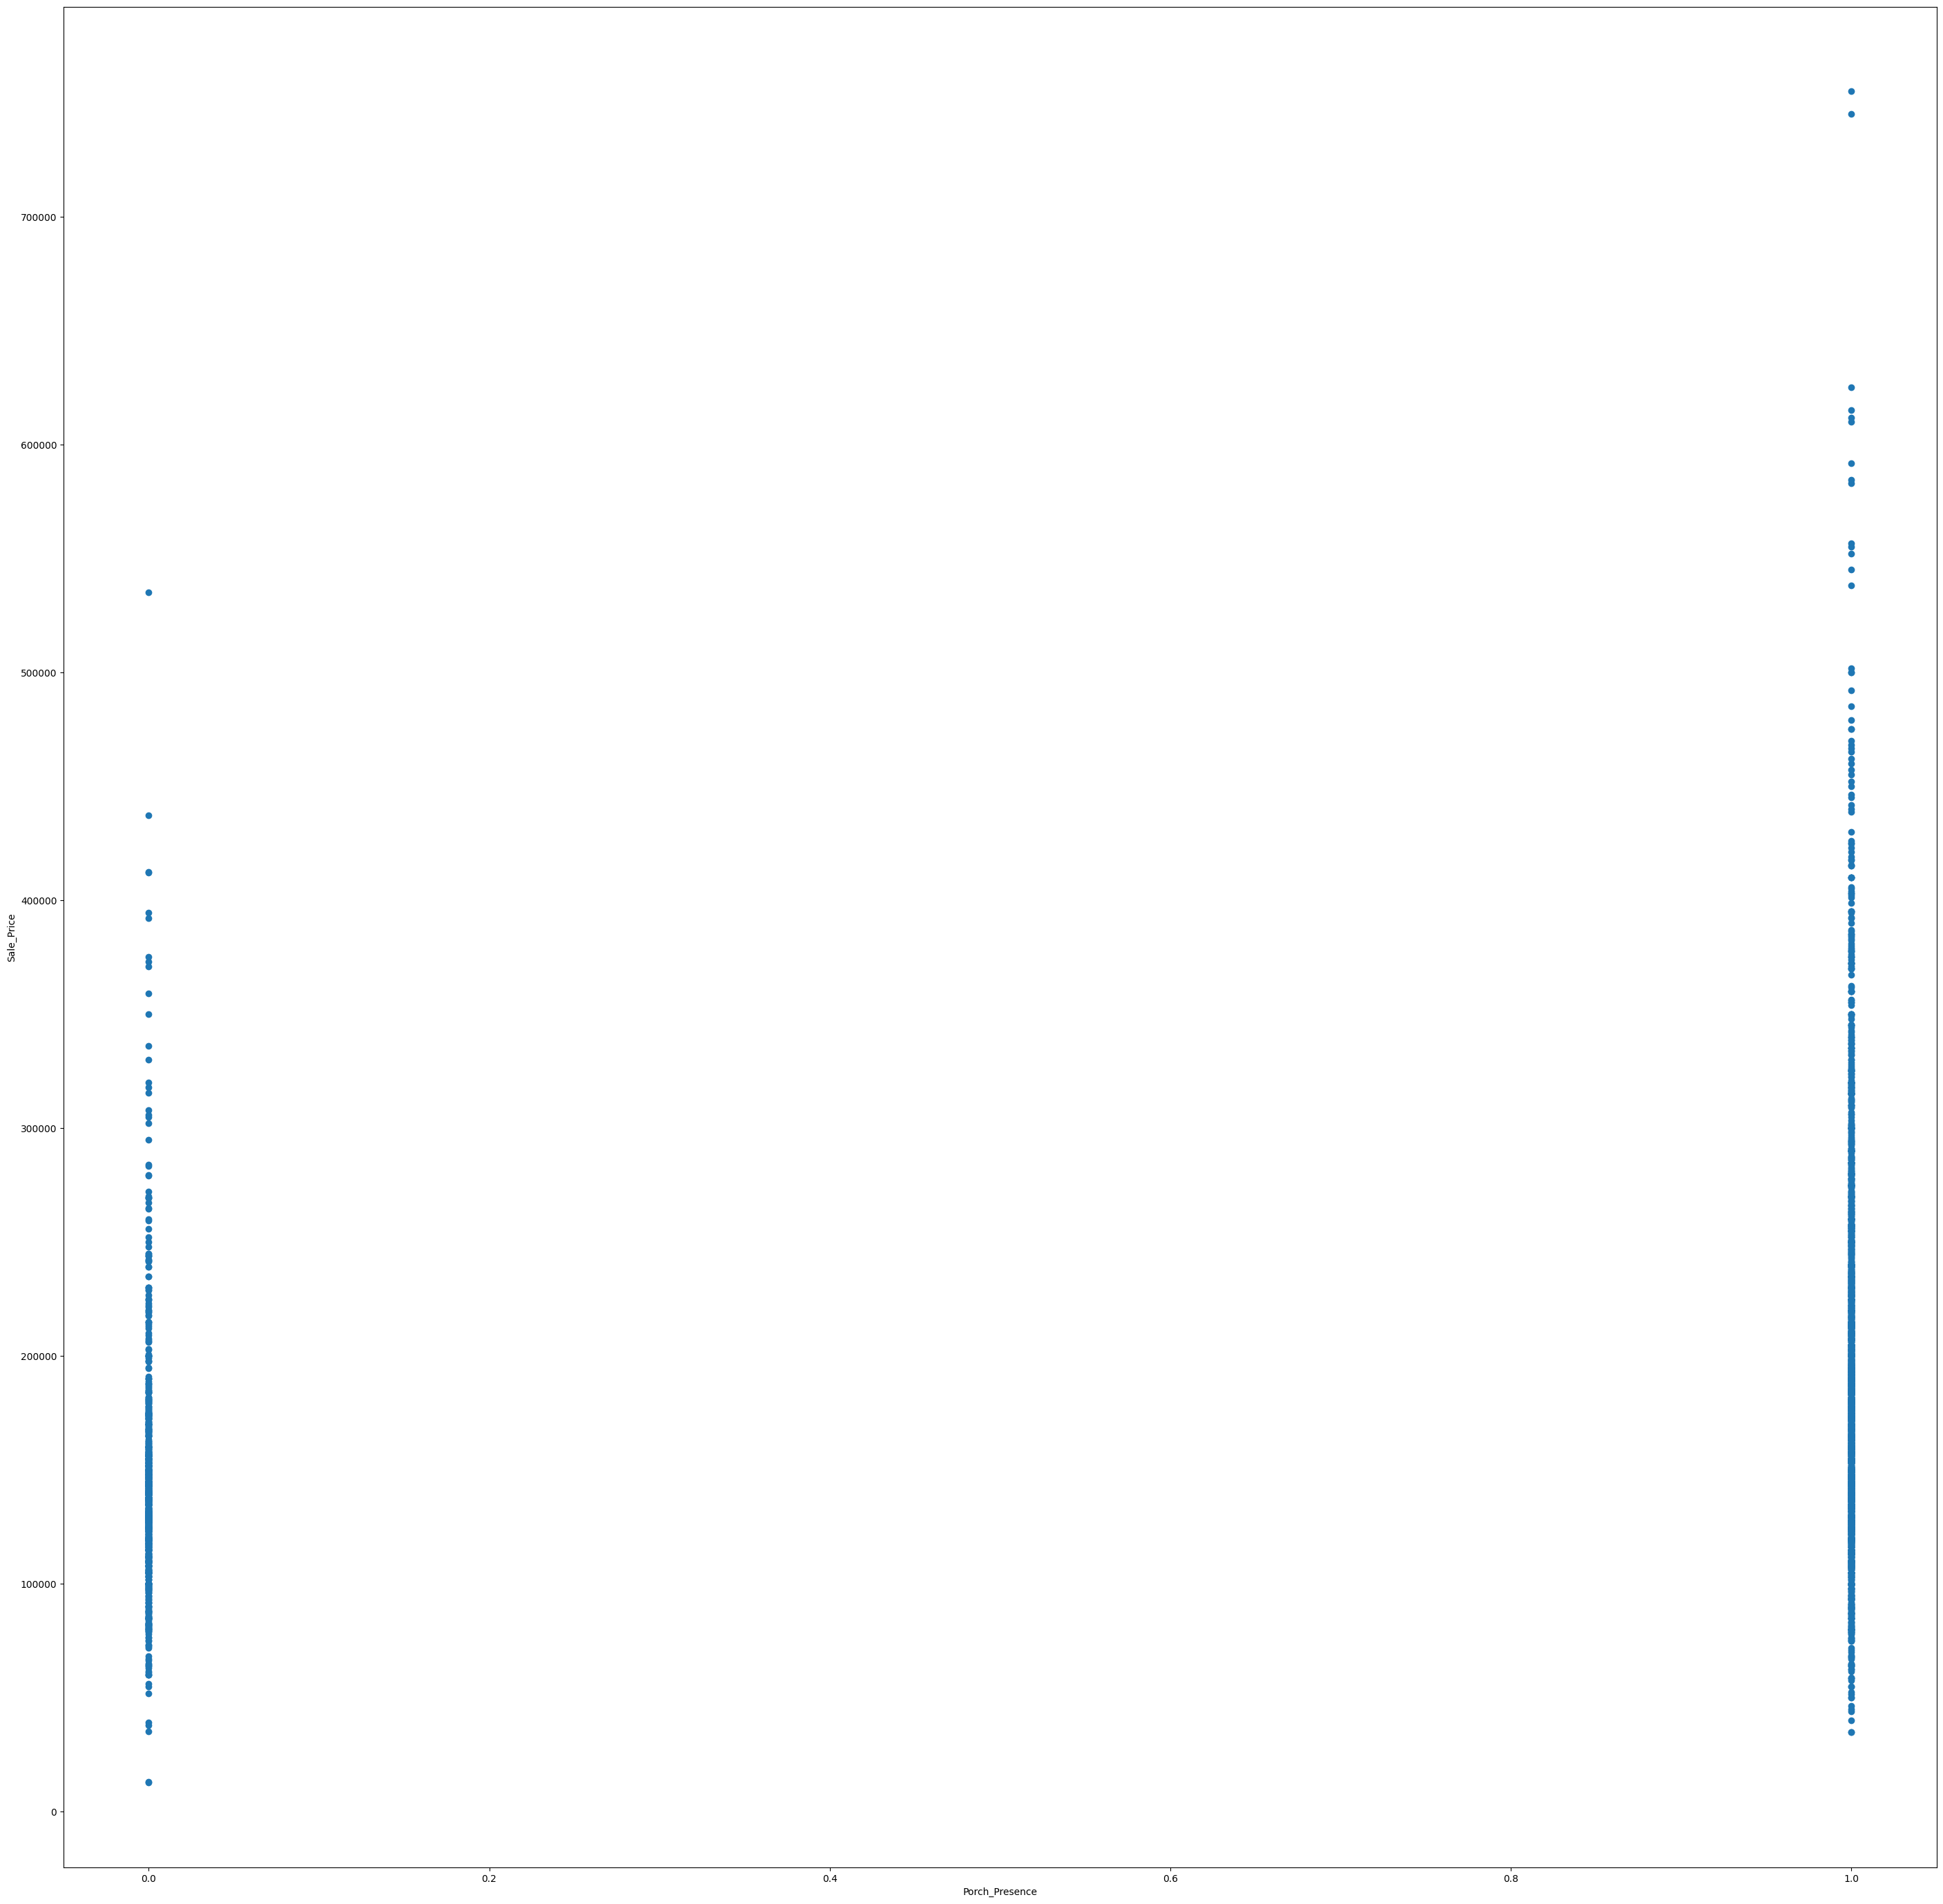

In [61]:
fig, ax = plt.subplots()
ax.scatter(temp_df['Porch_Presence'], df_features['Sale_Price'])
plt.xlabel('Porch_Presence')
plt.ylabel('Sale_Price')

Concatenazione dei due dataframe:

In [62]:
df_features = pd.concat([df_features, temp_df ], axis= 1)

Sempre per i motivi sopra, si eliminano le seguenti features. 

In [63]:
df_features = df_features.drop(columns = ['Open_Porch_SF', 'Enclosed_Porch', 'Three_season_porch', 'Screen_Porch'] , axis = 1)

Si verifica se il numero di colonne è effettivamente cambiato.

In [64]:
df_features.shape

(2930, 73)

<div class="alert alert-block alert-info" align = "center">
    <h1>Prezzo medio per quartiere</h1>
</div>

Si vuole aggiungere una nuova feature contenente il prezzo medio per quartiere. 

In [65]:
def Mean_Price_Neigh(dataframe):
    
    # Si crea un dizionario, la cui chiave è il nome di un quartiere e il cui valore è un array contenente la sommatoria dei prezzi delle abitazioni e il numero di esse
    diz = {}
    # Dataframe temporaneo
    temp_df = pd.DataFrame(dataframe, columns = ['Mean_Price_Neigh'])
    # k rappresenta l'indice delle righe della nuova colonna
    k = 0
    for neigh, price in zip(dataframe['Neighborhood'], dataframe['Sale_Price']):
        # Se il quartiere non è ancora presente nel dizionario, si aggiunge e si pone il prezzo pari a quello dell'abitazione corrente e si pone a 1 il counter delle abitazioni
        if (neigh not in diz):
            diz[neigh] = [price, 1]
        # Se il quartiere è già presente, si somma il prezzo dell'abitazione e si aggiunge 1 al counter delle abitazioni
        else:
            diz[neigh][0] += price
            diz[neigh][1] += 1

    # Calcolo della media
    k = 0
    for i in dataframe['Neighborhood']:
        
        temp_df['Mean_Price_Neigh'][k] = diz[i][0] / diz[i][1]
        
        k +=  1
    
    return temp_df

In [66]:
temp_df = Mean_Price_Neigh(df_features)

Anche in quest'ultimo caso si fa un grafico per individuare un'eventuale relazione con `Sale_Price`.

Text(0, 0.5, 'Sale_Price')

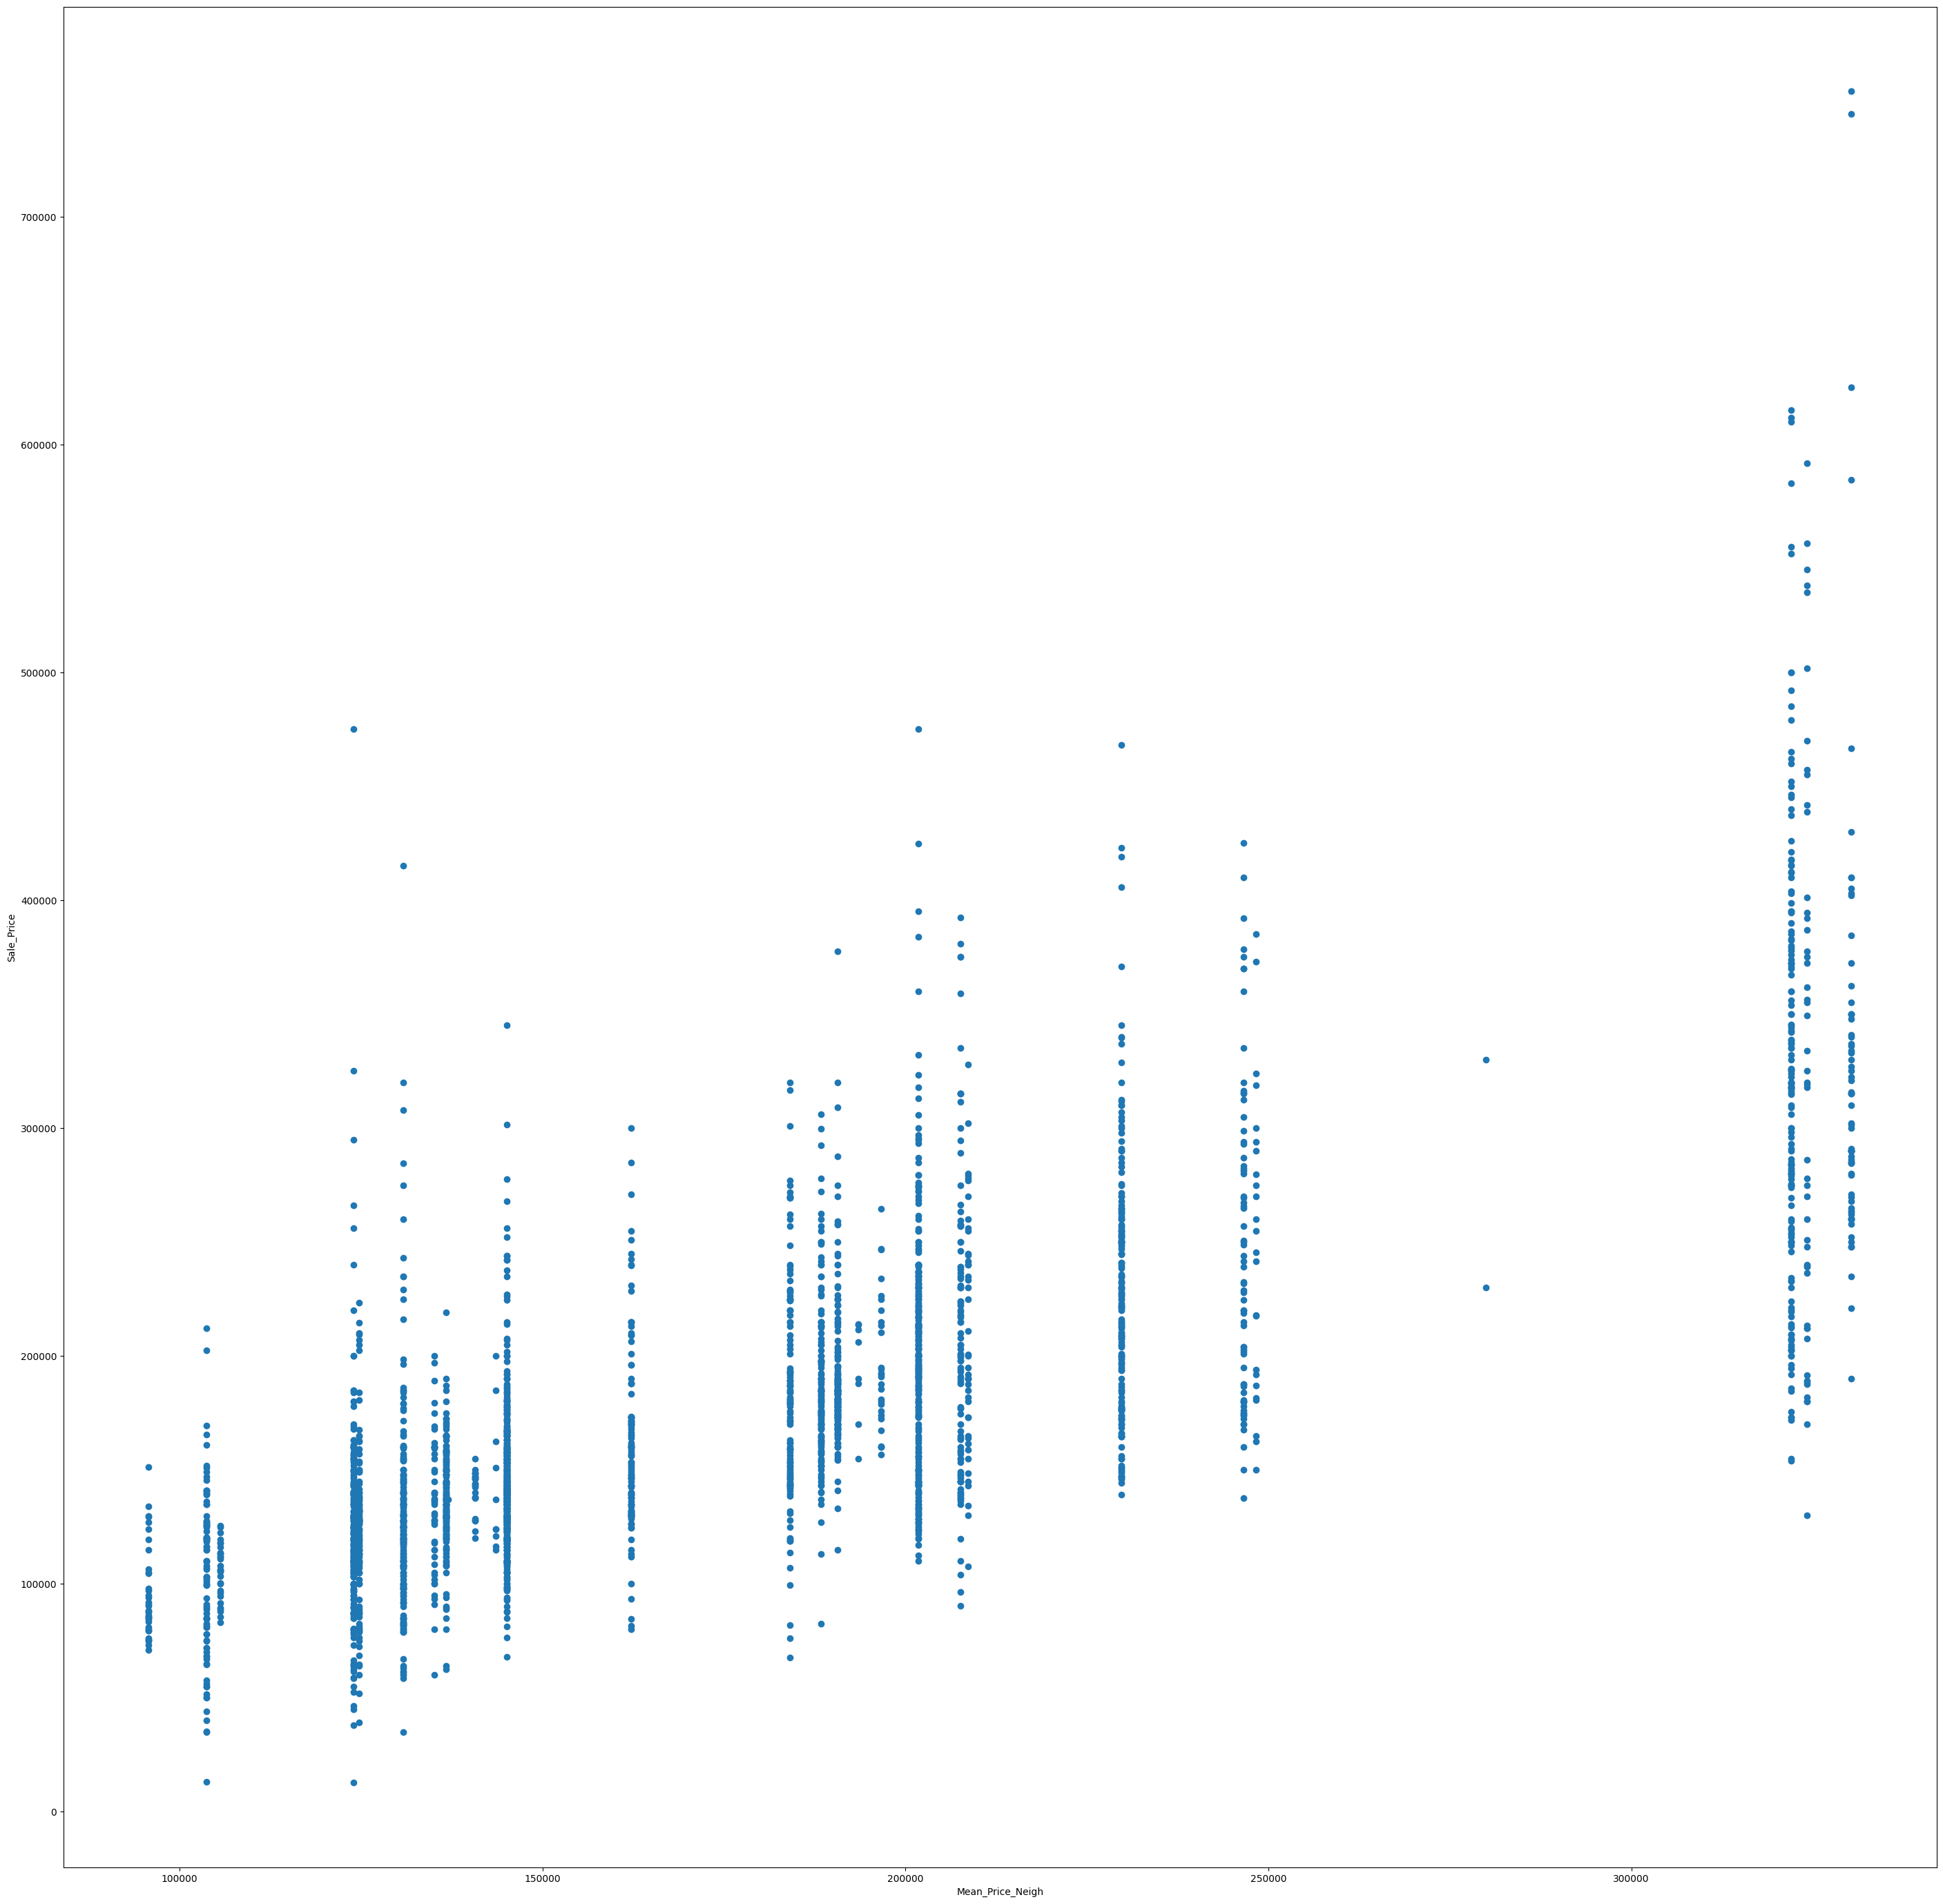

In [67]:
fig, ax = plt.subplots()
ax.scatter(temp_df['Mean_Price_Neigh'], df_features['Sale_Price'])
plt.xlabel('Mean_Price_Neigh')
plt.ylabel('Sale_Price')

Dal grafico si può evincere che più il prezzo medio per quartiere è alto, maggiore è il valore dell'abitazione e viceversa, più il prezzo medio per quartiere è basso, minore è il valore dell'abitazione. 

Ipoteticamente, si potrebbe supporre che i quartieri con prezzi medi elevati siano quartier particolarmente ricercati, mentre a prezzi medi bassi corrispondono quartieri con uno scarso interesse immobiliare.

Concatenazione dei due dataframe:

In [68]:
df_features = pd.concat([df_features, temp_df ], axis= 1)

Si verifica se il numero di colonne è effettivamente cambiato.

In [69]:
df_features.shape

(2930, 74)

<div class="alert alert-block alert-info" align = "center">
    <h1>Feature binarie</h1>
</div>

Come preannunciato, alcune features sono state modificate in base ai valori che contengono e soprattutto in base alla loro frequenza per permettere di dividere fra loro tali valori in modo più semplice.

Quali features si sono scelte?

In [70]:
df_features['Street'].value_counts()

Pave    2918
Grvl      12
Name: Street, dtype: int64

In [71]:
df_features['Alley'].value_counts()

No_Alley_Access    2732
Gravel              120
Paved                78
Name: Alley, dtype: int64

In [72]:
df_features['Utilities'].value_counts()

AllPub    2927
NoSewr       2
NoSeWa       1
Name: Utilities, dtype: int64

In [73]:
df_features['Condition_2'].value_counts()

Norm      2900
Feedr       13
Artery       5
PosA         4
PosN         4
RRNn         2
RRAe         1
RRAn         1
Name: Condition_2, dtype: int64

In [74]:
df_features['Roof_Matl'].value_counts()

CompShg    2887
Tar&Grv      23
WdShake       9
WdShngl       7
Membran       1
ClyTile       1
Roll          1
Metal         1
Name: Roof_Matl, dtype: int64

Come si può notare, la stra grande maggioranza delle istanze assume un valore rispetto agli altri, di conseguenza si è deciso di porre a 1 il valore più frequente e a 0 tutti gli altri.

Per quanto riguarda invece `Central_Air`, questa feature è composta da due soli valori e per questo verrà trasformata anch'essa in una feature binaria.

In [75]:
df_features['Central_Air'].value_counts()

Y    2734
N     196
Name: Central_Air, dtype: int64

Non si è scelto di eliminarle a priori perchè sono features che non sono intriseche ad altre e quindi potrebbero potenzialmente influire sulla buona riuscita della predizione del modello.

In [76]:
def binary_Features(dataframe):
    
    # Sostituzione per 'Street'
    dataframe['Street'].replace(to_replace = ['Pave', 'Grvl'], value = [1, 0], inplace = True )
    
    # Sostituzione per 'Alley'
    dataframe['Alley'].replace(to_replace = ['No_Alley_Access', 'Paved', 'Gravel'],
                  value = [0, 1, 1], inplace = True)
    
    # Sostituzione per 'Utilities'
    dataframe['Utilities'].replace(to_replace = ['AllPub', 'NoSewr', 'NoSeWa'], value = [1, 0, 0], inplace = True)
    
    # Sostituzione per 'Condition_2'
    dataframe['Condition_2'].replace(to_replace = ['Norm', 'Feedr', 'Artery', 'PosA', 'PosN', 'RRNn', 'RRAe', 'RRAn'], 
                                    value = [1, 0, 0, 0, 0, 0, 0, 0], inplace = True)
    
    # Sostituzione per 'Roof_Matl'
    dataframe['Roof_Matl'].replace(to_replace = ['CompShg','Tar&Grv','WdShake','WdShngl', 'Membran','ClyTile' ,'Roll' , 'Metal'],
                  value = [1, 0, 0, 0, 0, 0, 0, 0], inplace = True)
    
    # Sostituzione per 'Central_Air'
    dataframe['Roof_Matl'].replace(to_replace = ['Y', 'N'],
                  value = [1, 0], inplace = True)

In [77]:
binary_Features(df_features)

Come esempio dimostrativo, si mostra come ora si presenta la feature `Condition_2`:

In [78]:
df_features['Condition_2']

0       1
1       1
2       1
3       1
4       1
       ..
2925    1
2926    1
2927    1
2928    1
2929    1
Name: Condition_2, Length: 2930, dtype: int64

<div class="alert alert-block alert-info" align = "center">
    <h1>Feature ambigue</h1>
</div>

Si vogliono far notare delle feature particolari: `Electrical` e `Fence`

In [79]:
df_features['Fence'].value_counts()

No_Fence             2358
Minimum_Privacy       330
Good_Privacy          118
Good_Wood             112
Minimum_Wood_Wire      12
Name: Fence, dtype: int64

In [80]:
df_features['Electrical'].value_counts()

SBrkr      2682
FuseA       188
FuseF        50
FuseP         8
Unknown       1
Mix           1
Name: Electrical, dtype: int64

Sembrerebbe che entrambe tali feature comprendano valori riferiti a diversi ambiti.

In particolare
- `Fence` ha valori riguardo il materiale della recinzione e la privacy che questa offre;
- `Electrical` ha valori riguardo il tipo di elettricità e una scala di qualità di essa.

Se si provasse a dividere queste due feature in 4 feature differenti denominate come `Fence_Material`, `Fence_Privacy`, `Electrical_Type` e `Electrical_Qual` si perderebbero informazioni!

Perché?

Si prenda ad esempio la feature `Fence`:
- Se un'istanza avesse l'informazione riguardo la privacy che la recinzione offre, come sapere di quale materiale è costituita?
- Se un'istanza avesse l'informazione riguardo al materiale, si può semplicemente dedurre che se tale valore è `Good_Wood` allora la privacy è `Good_Privacy`?
- Se un'istanza avesse l'informazione riguardo al materiale, si può semplicemente dedurre che se tale valore è `Minimum_Wood_Wire` allora la privacy è `Minimun_Privacy`?

Si prenda ad esempio la feature `Electrical`:
- Se un'istanza avesse l'informazione riguardo il tipo, come sapere il valore della scala di qualità?
- Se un'istanza avesse l'informazione riguardo la scala, come sapere il valore del tipo?

Onde evitare di perdere informazione si lasciano così tali features.

Tuttavia, dato che mescolano informazioni di tipo differente trattandole come se fossero nello stesso ambito si è deciso di eliminarle.

In [81]:
df_features = df_features.drop(columns = ['Fence', 'Electrical'] , axis = 1)

Si verifica se il numero di colonne è effettivamente cambiato.

In [82]:
df_features.shape

(2930, 72)

(Si trasforma tale dataframe in un file csv che servirà nel Notebook4).

In [83]:
df_features.to_csv('dataset_per_CatBoost.csv', index = False)

Si sono sistemate le features categoriche, ma non tutte!

Qui di seguito viene applicata la tecnica del One-Hot Encoding (come nel Notebook1) per rendere questo dataset con meno feature un file csv da poi poter richiamare con più facilità nei seguenti notebook.

In [84]:
def data_preparation(dataframe):
    columns_names = np.array(dataframe.columns)
    first_values = np.array(dataframe.iloc[0])
    return columns_names, first_values

In [85]:
# Nomi delle colonne e primi valori di ogni colonna
columns_names, first_values = data_preparation(df_features)

In [86]:
# Funzione che pone a 'False' le features categoricali e a 'True' le features numeriche
def num_or_str():
    rmv= []
    for i in range(len(first_values)):
        if isinstance(first_values[i], str):
            rmv.append(False)
        else:
            rmv.append(True)
    return rmv

In [87]:
def names(dataframe, lista):
    tmp = []
    for i in lista:
        tmp.append(dataframe.columns[i])
    return tmp

In [88]:
from sklearn.preprocessing import OneHotEncoder

def process_data(dataframe):
    
    # Features numeriche
    is_numerical  = np.array(num_or_str())
    # 'numerical_names' è una lista che contiene i nomi delle features numeriche
    numerical_names = names(dataframe, np.flatnonzero(is_numerical))
    All_enc = pd.DataFrame(dataframe, columns = numerical_names)
    
    # Features categoriali
    # 'categorical_names' è una lista che contiene i nomi delle features categoriche
    categorical_names = names(dataframe, np.flatnonzero(is_numerical == False))
    oh = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
    oh.fit(dataframe[categorical_names])
    
    encoded = oh.transform(dataframe[categorical_names])
    All_enc = All_enc.fillna(0.0)
    for i,col in enumerate(oh.get_feature_names_out()):
        All_enc[col] = encoded[:,i]
    All_enc.columns = All_enc.columns.astype(str)
    
    return All_enc

In [89]:
df_clean = process_data(df_features)

C:\Users\Serena\AppData\Local\Temp\ipykernel_8948\1388710522.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  All_enc[col] = encoded[:,i]
C:\Users\Serena\AppData\Local\Temp\ipykernel_8948\1388710522.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  All_enc[col] = encoded[:,i]
C:\Users\Serena\AppData\Local\Temp\ipykernel_8948\1388710522.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at onc

Si guarda la shape del nuovo dataset.

In [90]:
df_clean

,Lot_Frontage,Lot_Area,Street,Alley,Utilities,Condition_2,Overall_Qual,Overall_Cond,Year_Built,Year_Remod_Add,...,Sale_Type_New,Sale_Type_Oth,Sale_Type_VWD,Sale_Type_WD,Sale_Condition_Abnorml,Sale_Condition_AdjLand,Sale_Condition_Alloca,Sale_Condition_Family,Sale_Condition_Normal,Sale_Condition_Partial
0,141,31770,1,0,1,1,4,3,1960,1960,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,80,11622,1,0,1,1,3,4,1961,1961,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,81,14267,1,0,1,1,4,4,1958,1958,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,93,11160,1,0,1,1,6,3,1968,1968,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,74,13830,1,0,1,1,3,3,1997,1998,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,37,7937,1,0,1,1,4,4,1984,1984,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2926,0,8885,1,0,1,1,3,3,1983,1983,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2927,62,10441,1,0,1,1,3,3,1992,1992,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2928,77,10010,1,0,1,1,3,3,1974,1975,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [91]:
df_clean.shape

(2930, 239)

In [92]:
df_clean.to_csv(r'dataset_pulito.csv', index = False)

<div class="alert alert-block alert-warning" align = "center">
    <h1>OUTLIERS SUL DATASET PULITO</h1>
</div>

Come anticipato, anche per il dataset pulito viene adottata la stessa procedura per individuare gli outliers utilizzata sul dataset fornito.

In [93]:
X_train_80_clean, X_test_clean, y_train_80_clean, y_test_clean = split(df_clean)

<div class="alert alert-block alert-success" align = "center">
    <h1>LocalOutlierFactor</h1>
</div>

In [94]:
num_LOF, num_norm_LOF, LOF_out = Outliers_LOF(X_train_80_clean, y_train_80_clean)

In [95]:
print("Numero di outliers con LOF: ", num_LOF)
print("Numero di inliers con LOF: ", num_norm_LOF)

Numero di outliers con LOF:  235
Numero di inliers con LOF:  2109


<div class="alert alert-block alert-success" align = "center">
    <h1>IsolationForest</h1>
</div>

In [96]:
num_IF, num_norm_IF, IF_out = Outliers_IF(X_train_80_clean, y_train_80_clean)

C:\Users\Serena\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [97]:
print("Numero di outliers con IF: ", num_IF)
print("Numero di inliers con IF: ", num_norm_IF)

Numero di outliers con IF:  71
Numero di inliers con IF:  2273


<div class="alert alert-block alert-success" align = "center">
    <h1>Outliers comuni</h1>
</div>

In [98]:
X_clean_train_no_out, y_clean_train_no_out = Common_Outliers(X_train_80_clean, y_train_80_clean, LOF_out, IF_out)

Si verifica se il numero di colonne è effettivamente cambiato.

In [99]:
X_clean_train_no_out.shape

(2320, 238)

In [100]:
y_clean_train_no_out.shape

(2320,)

I seguenti comandi servono per trasformare i dataframe puliti senza outliers in un file csv.

In [101]:
df_clean_no_out = pd.concat([X_clean_train_no_out, y_clean_train_no_out], axis = 1)

In [102]:
df_clean_no_out.to_csv(r'training_clean_wo_outliers.csv', index = False)